In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import sys

import btk
import btk.plot_utils
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions
import astropy.table

import pyfftw.interfaces.numpy_fft as fft
import pyfftw
import galsim


from scripts.BTK_generator import BTK_blend_generator as btk_generator
from scripts.FFT_calcs import FFT_IFFT_calc 
from scripts.shearing import visualize_shear

**Work for tomorrow:**
1. Figure out the normalization between the analytical and FFT FT's. 
    - The simple solution that David recommended (ie. multiply or divide the FFT solution by $N^2$) doesn't work.
    - Try doing the full path (Input $\rightarrow$ FT $\rightarrow$ IFT(FT)) to see if there is something wrong in there
2. Redo/check the math for the sheared response. For `g1` the response is inverted compared to what we should expect
    - I bet the y-component/g2-component has a negative when it should be positive
3. Get the normalization for the round/sheared galaxy profiles
4. Finalize the "Noise effect on FT's" on section 3 to be more flushed out and modular (ie. more functions)
5. Make many of the functions in this notebook into scripts 

# 0. Goal of this Notebook

David said it would be good to better understand what was happening with the FT, so he suggested writing in code & by hand what the FT of a round 2D gaussian and an elliptical 2D gaussian is.

This notebook is the code portion of this task. 

**Work for next time:**
1. Might be good to make my own function for 2D gaussian that has the ability to create an elliptical gaussian. Do the FT of this, so I know what to expect
2. Compare what I got in (1.) with the answers by-hand
3. Do what I did in (1.), but using `GalSim`. I already have the `Galsim` 2D round gaussian, but I'm unsure what exactly David wanted from me when he was representing the elliptical galaxy in terms of $\sigma_1, \sigma_2, \rho$. I know I can represent it in terms of the reduced shear components $g_1, g_2, \sigma$ as in the photo ($\sigma \rightarrow e \hspace{02mm} \text{in `galsim`}$). And I know `GalSim` has this functionality, so would be good to do it in both ways potentially.

**NOTE:** This [wiki](https://en.wikipedia.org/wiki/Gravitational_lensing_formalism#Measures_of_ellipticity) page may be useful for understanding exactly what is happening/how shear is defined. But note that the `galsim` implementation of shear is different than is used in papers. For the version of shear that changes the shape of the object we want to use `lens` in `GalSim`.

# 1. Analytical Sheared Gaussians

### 1.2.1 Round Sheared Gaussian

Using Mandelbaum's notation for reduced shear components, shear and magnification are parameterized as: 

$$\begin{bmatrix} x_u \cr y_u\end{bmatrix} = (1-\kappa)\begin{bmatrix} 1-g_1 & -g_2 \\ -g_2 & 1+g_1 
\end{bmatrix} \begin{bmatrix} x_l \cr y_l\end{bmatrix}$$

where:
- $(x_u, y_u$) are the unlensed coordinates
- $(x_l, y_l)$ are the lensed coordinates
- $g_i = \gamma_i/(1-\kappa)$ is the form of the reduced shear components

For our code, our images represent the **lensed** galaxy images (i.e. they are being seen as if they were being viewed after the photons traveled through the DM). Thus, we want to know how to go from lensed $\rightarrow$ unlensed.

---

This means we need to know how to parameterize the covariance matrix, $C^{-1}$, of the vectorized gaussian function, in the face of a shear/magnification response. To do this we start with the **non-rotated 2D Gaussian** equation:  $$f(x,y) = \frac{1}{2\pi \sigma_x \sigma_y} \text{ exp}\Big(-\frac{x^2}{2\sigma_x^2} - \frac{y^2}{2\sigma_y^2}\Big)$$

We note that the factor in the exponent can be vectorized like so: $$\begin{align*} f(x,y) &= \text{exp}\Big(-\frac{1}{2} \xi \Big)\\
\xi &= \vec{r}^{T} C^{-1} \vec{r}\\
\vec{r} &= \begin{bmatrix} x_u \cr y_u\end{bmatrix} \\
C^{-1} &= \begin{bmatrix} \sigma_x^2 & 0 \\ 0 & \sigma_y^2 
\end{bmatrix}^{-1}
\end{align*}$$

If we call the shear transformation presented above from [Mandelbaum's review paper](https://arxiv.org/pdf/1710.03235.pdf) the matrix $S$, where: $$S = (1-\kappa)\begin{bmatrix} 1-g_1 & -g_2 \\ -g_2 & 1+g_1 
\end{bmatrix}$$

We can parameterize a new covariance matrix $C'^{-1}$, such that it includes the shear response of the galaxy via DM in the covariance matrix: $$\begin{align*} C'^{-1} &= S^{T} C^{-1} S\\
 C'^{-1} &= (1-\kappa)^2 \begin{bmatrix} \frac{(1-g_1)^2}{\sigma_x^2} + \frac{g_2^2}{\sigma_y^2} & -\frac{g_2(1-g_1)}{\sigma_x^2} - \frac{g_2(1+g_1)}{\sigma_y^2} \\ -\frac{g_2(1-g_1)}{\sigma_x^2}-\frac{g_2(1+g_1)}{\sigma_y^2} & \frac{g_2^2}{\sigma_x^2}+\frac{(1+g_1)^2}{\sigma_y^2} 
\end{bmatrix} \end{align*}$$

Using our reparameterized covariance matrix $C'^{-1}$, a non-rotated galaxy profile is: 
$$\begin{align*}
f(x,y) &= \frac{1}{A} \text{exp}(-\frac{1}{2} \xi) \\
\xi &= \vec{r}^{T} C'^{-1} \vec{r} \\
f(x,y) &= \frac{1}{A} \text{exp} \Big(-\frac{(1-\kappa)^2}{2} \Big[\frac{x^2(1-g_1)^2 + y^2g_2^2 - 2xyg_2(1-g_1)}{\sigma_x^2} + \frac{x^2g_2^2 + y^2(1+g_1)^2 - 2xyg_2(1+g_1)}{\sigma_y^2}\Big]\Big)
\end{align*}$$
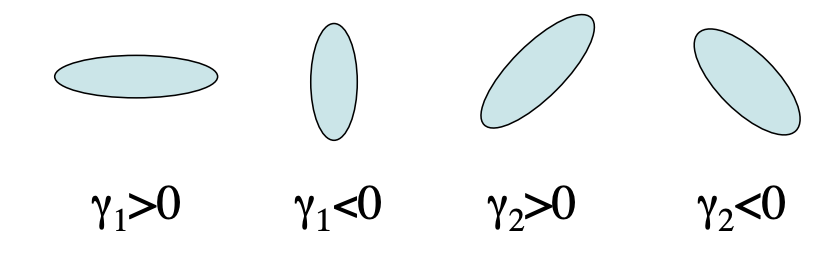
Figure taken from [these slides](http://mwhite.berkeley.edu/Lensing/SantaFe04.pdf)

**Kappa only**

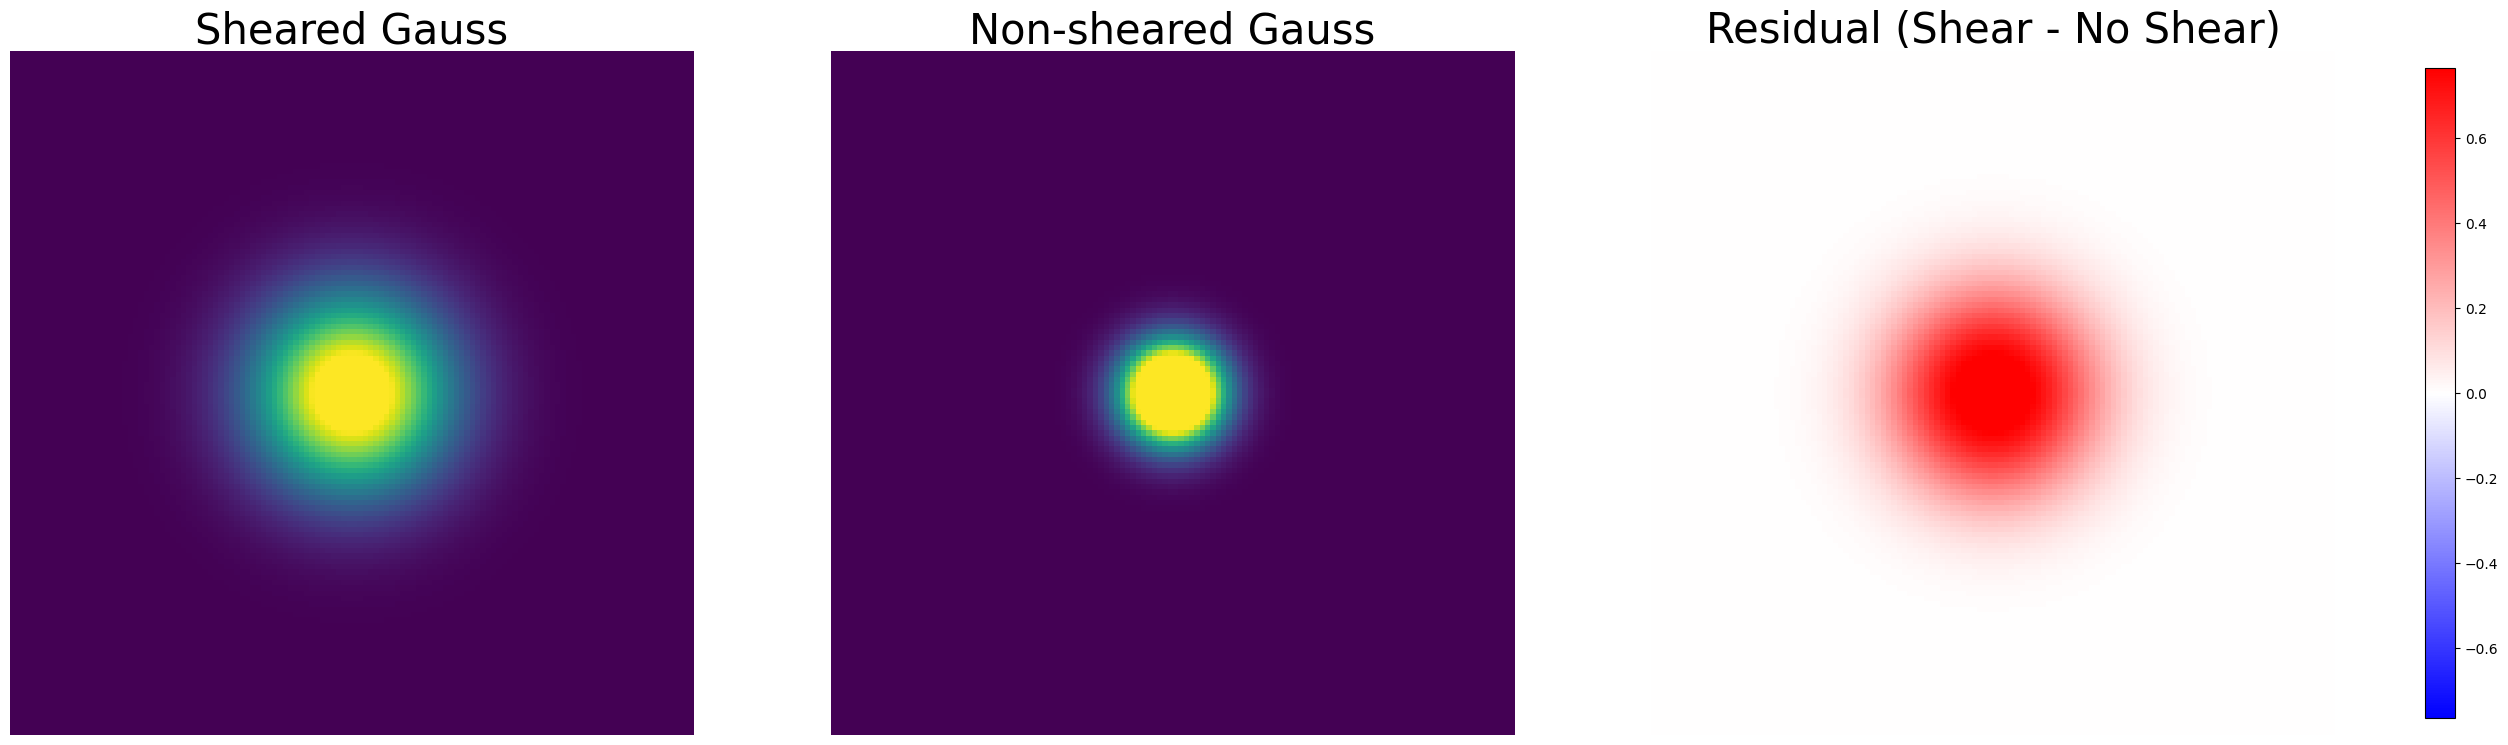

In [2]:
visualize_shear(sigma_x=1.0,
                sigma_y=1.0,
                rho=0.0,
                g1=0.0, 
                g2=0.0, 
                kappa=0.5)

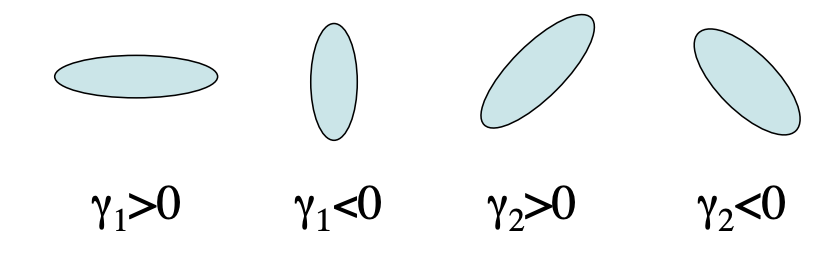

**`g1` only**

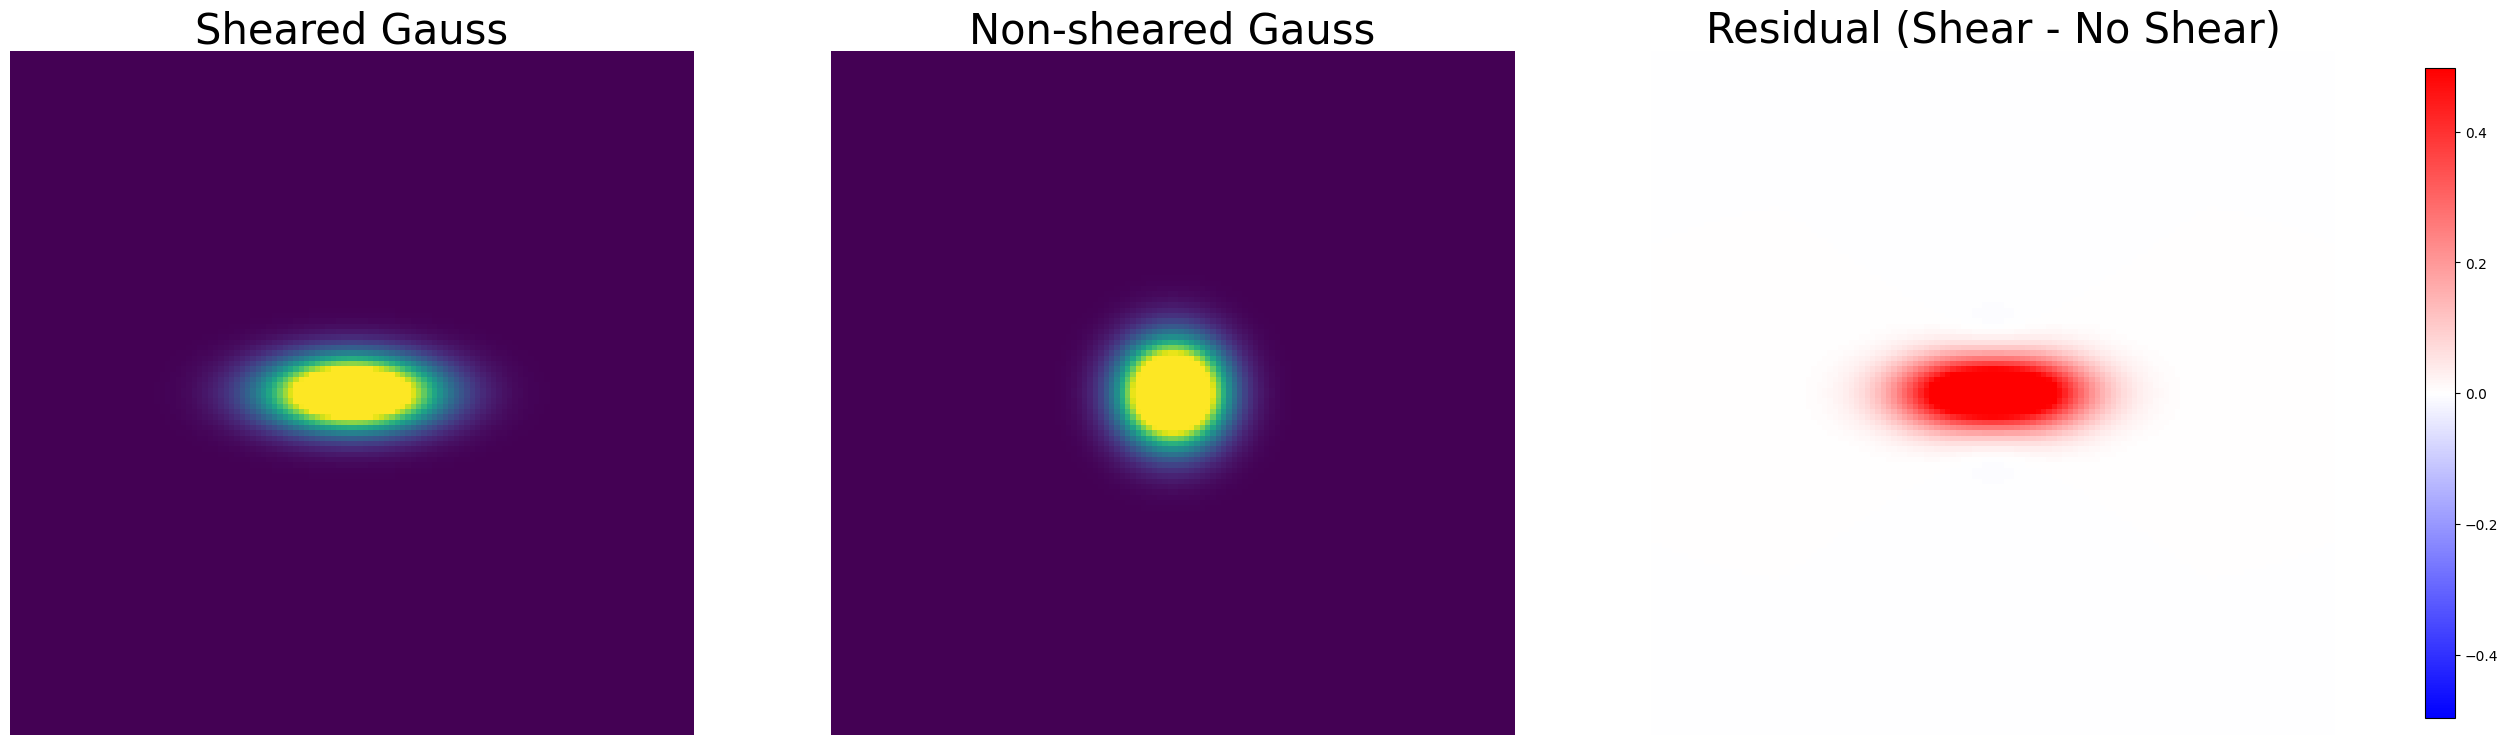

In [3]:
visualize_shear(sigma_x=1.0,
                sigma_y=1.0,
                rho=0.0,
                g1=0.4, 
                g2=0.0, 
                kappa=0.0)

**`g2` only**

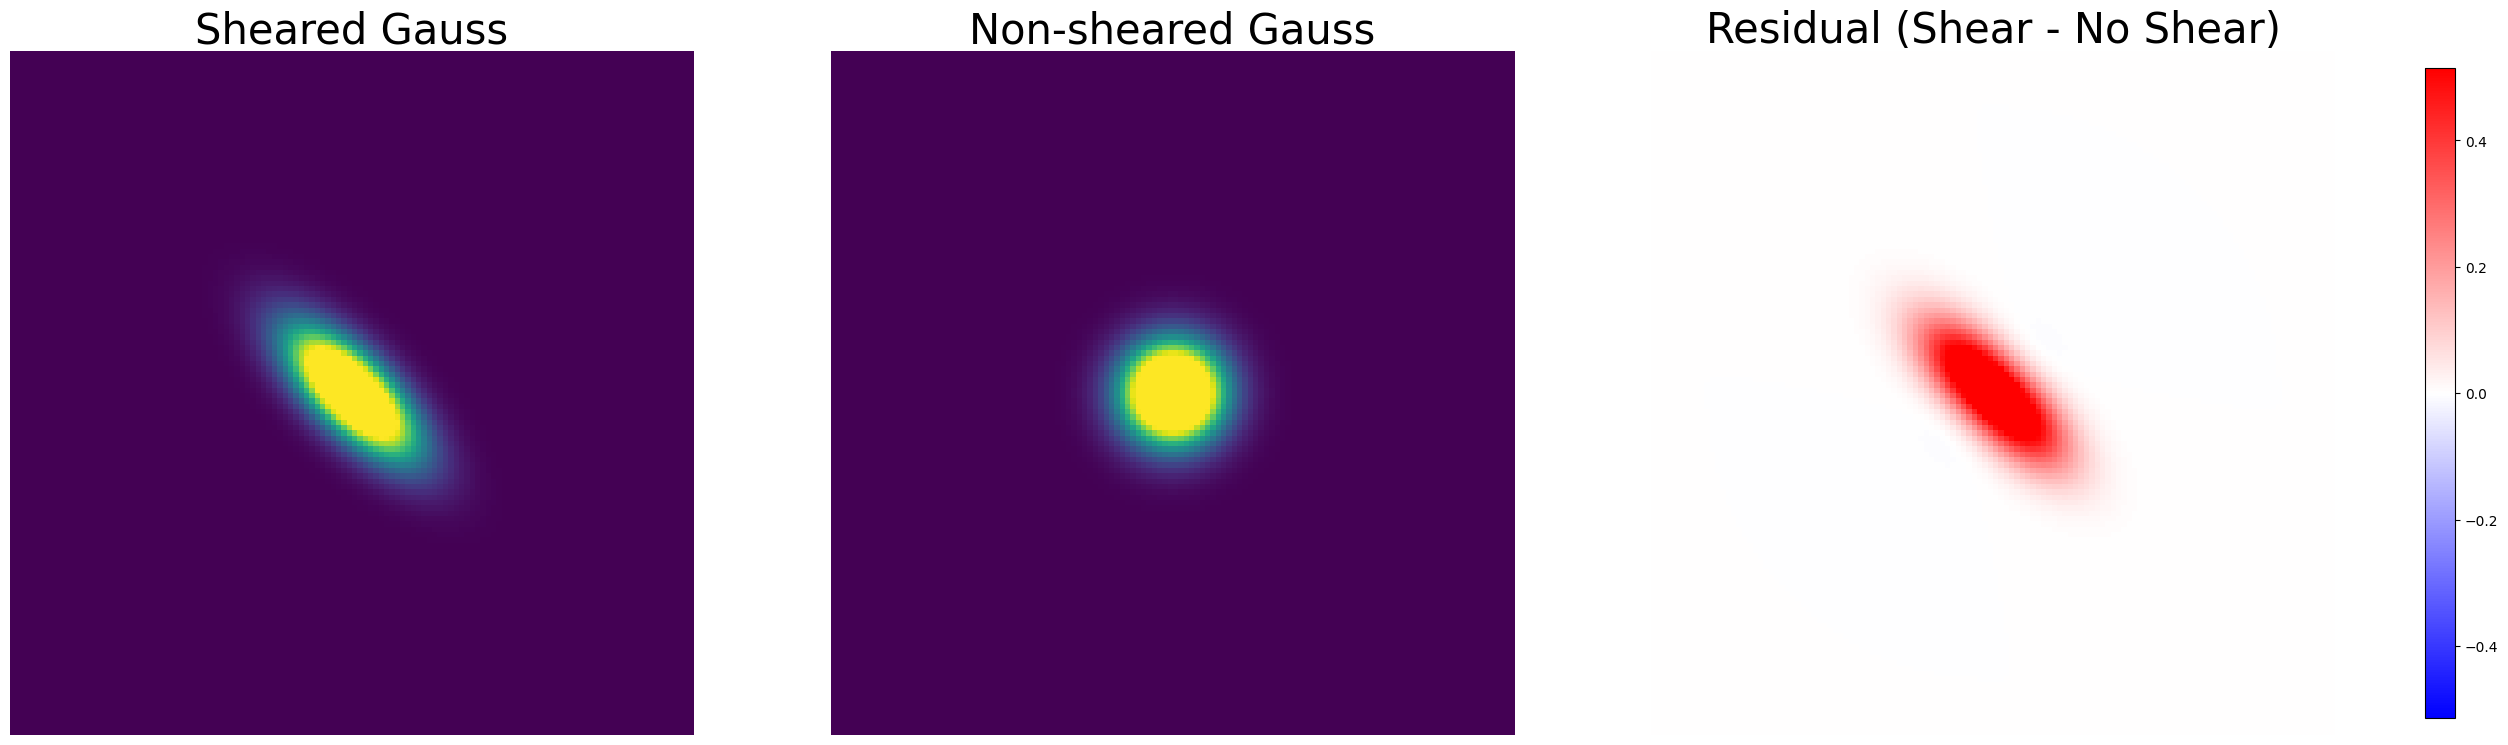

In [4]:
visualize_shear(sigma_x=1.0,
                sigma_y=1.0,
                rho=0.0,
                g1=0.0, 
                g2=-0.4, 
                kappa=0.0)

**`g1 + g2`**

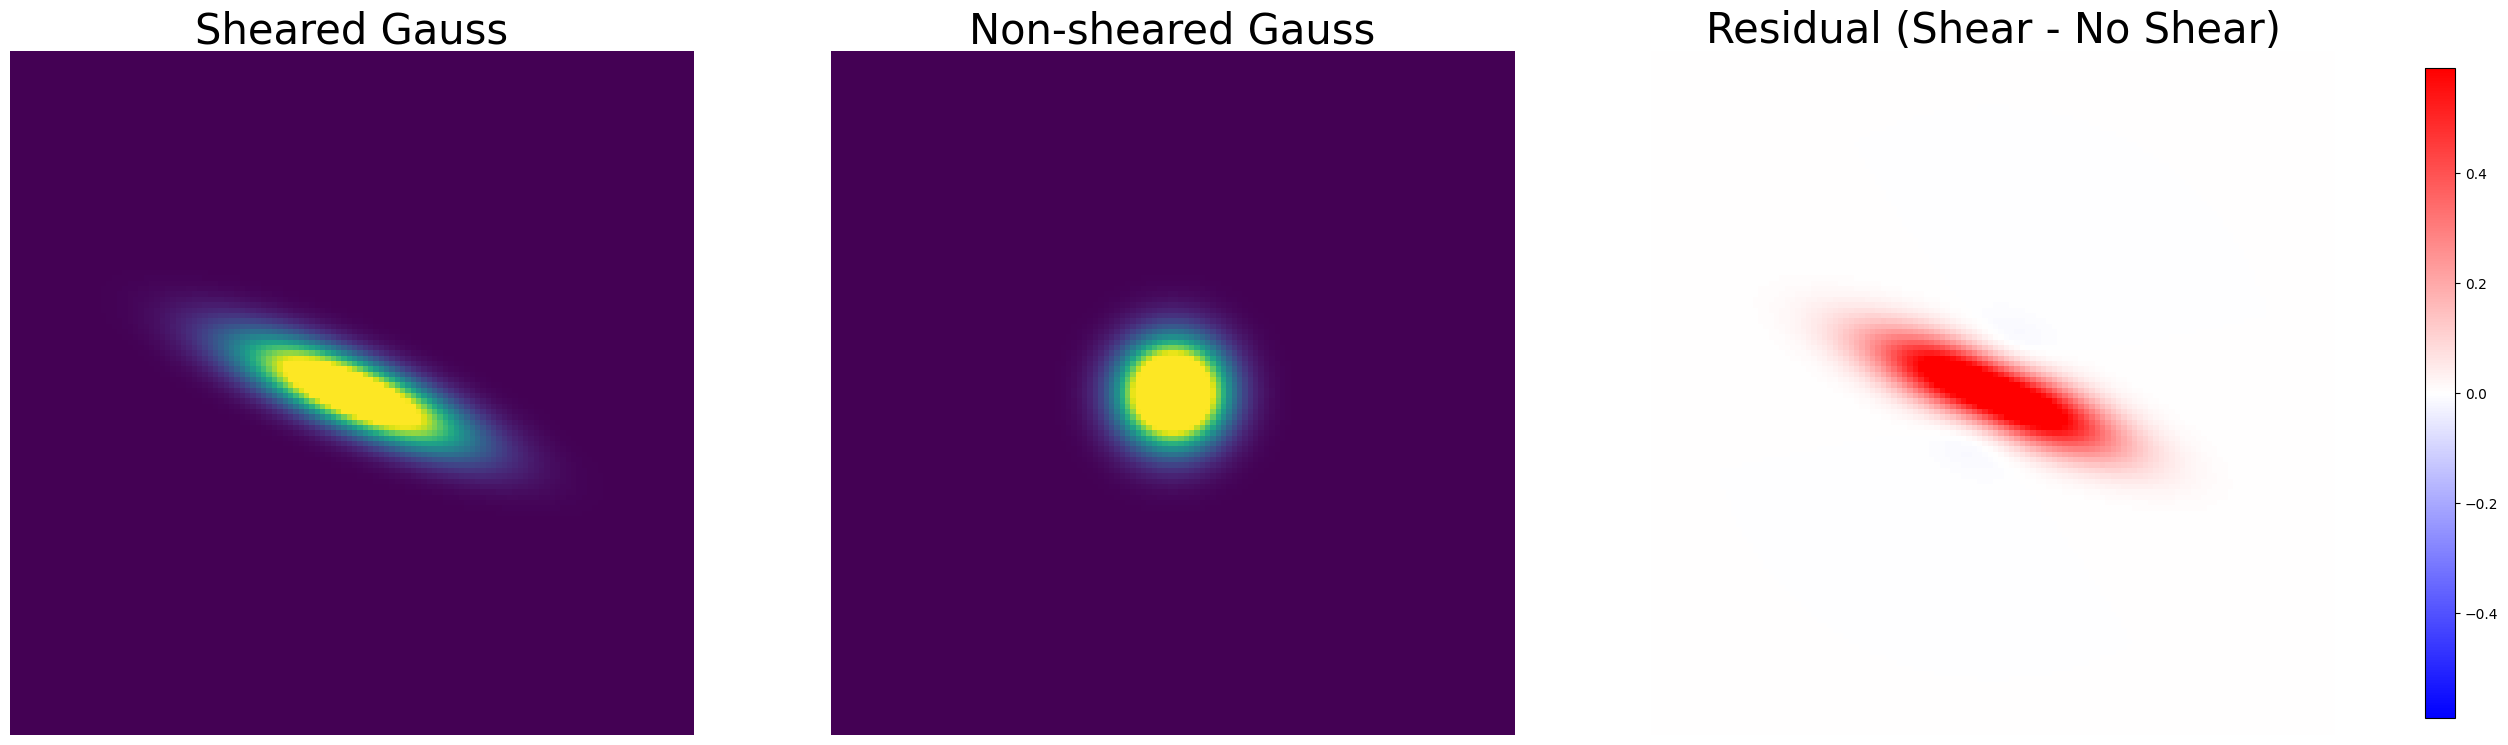

In [5]:
visualize_shear(sigma_x=1.0,
                sigma_y=1.0,
                rho=0.0,
                g1=0.4, 
                g2=-0.4, 
                kappa=0.0)

**`kappa + g1 + g2`**

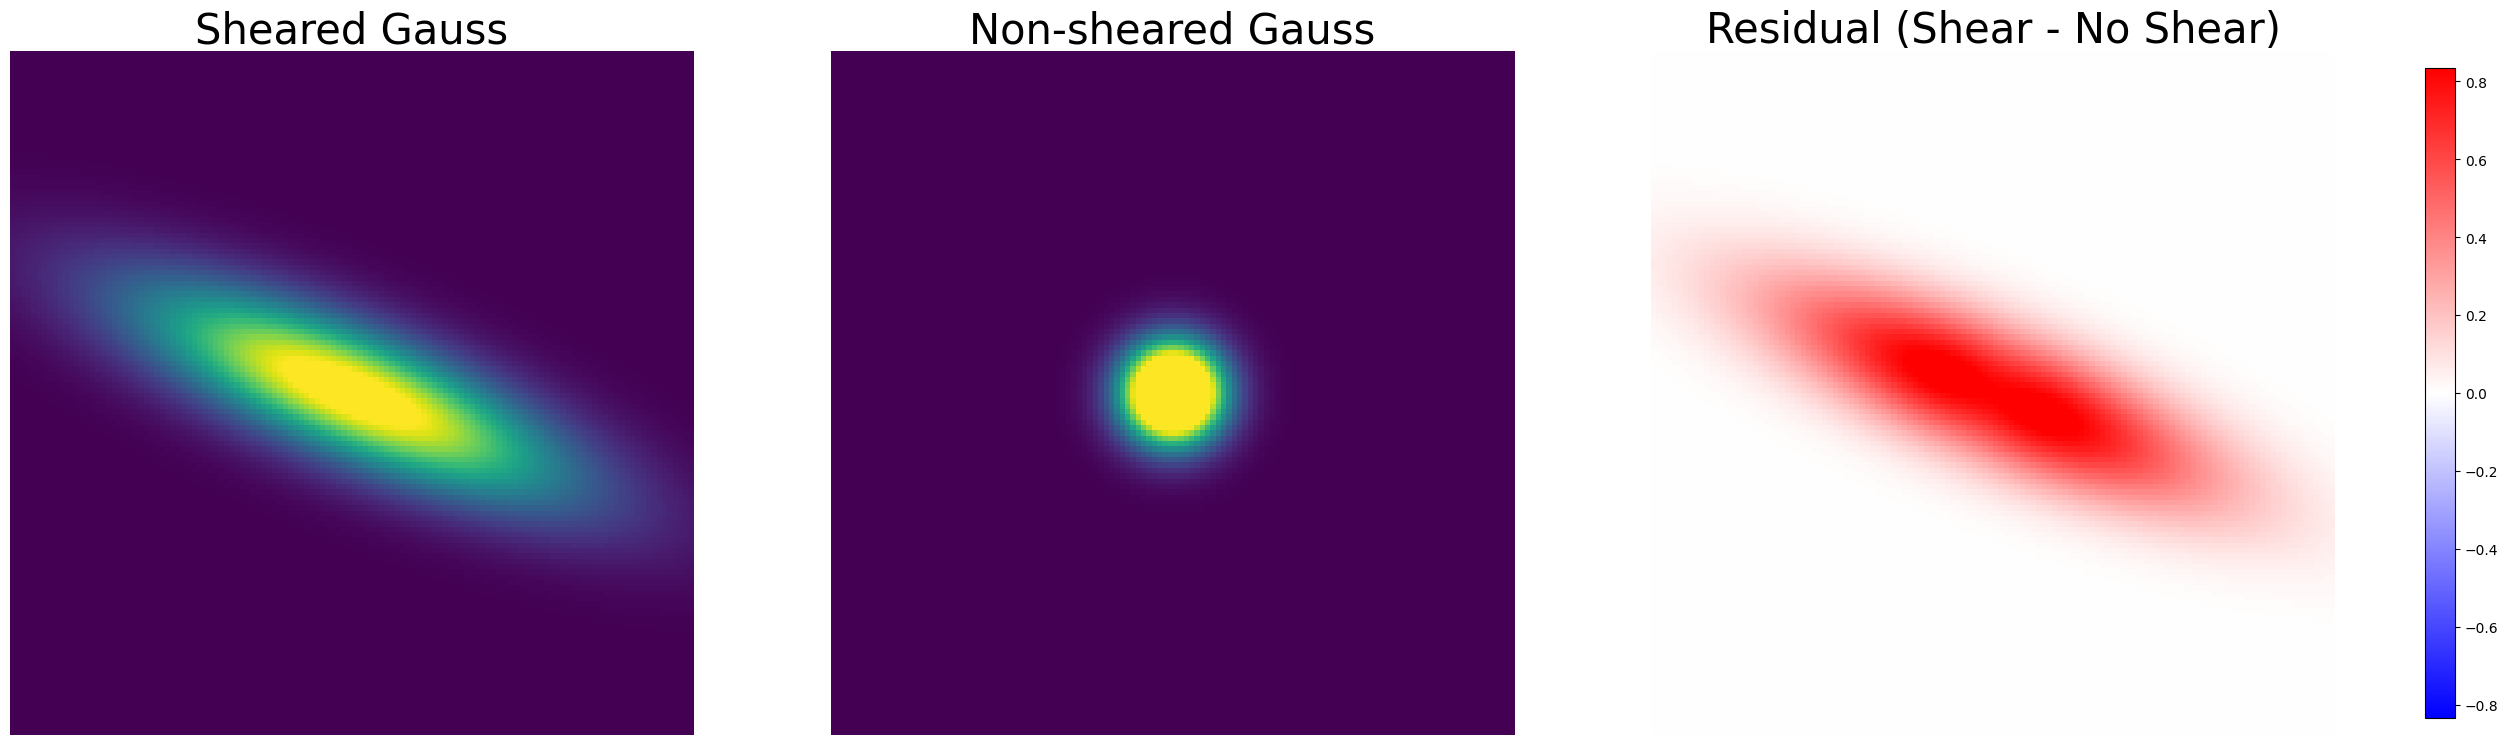

In [6]:
visualize_shear(sigma_x=1.0,
                sigma_y=1.0,
                rho=0.0,
                g1=0.4, 
                g2=-0.4, 
                kappa=0.5)

### 1.2.2 Elliptical Sheared Gaussian

Now to do the same parameterization we did above, but for the **rotated 2D Gaussian**:$$f(x,y) = \frac{1}{2\pi \sigma_x \sigma_y \sqrt{1-\rho^2}} \text{ exp}\Big(-\frac{(x-x_0)^2}{2\sigma_x^2(1-\rho^2)} - \frac{(y-y_0)^2}{2\sigma_y^2(1-\rho^2)} + \frac{(x-x_0)(y-y_0)\rho}{\sigma_x\sigma_y(1-\rho^2)}\Big)$$


Which we know can be vectorized like so: $$\begin{align*} f(x,y) &= \text{exp}\Big(-\frac{1}{2} \xi \Big)\\
\xi &= \vec{r}^{T} S^{T} C^{-1} S\vec{r}\\
\vec{r} &= \begin{bmatrix} x_u \cr y_u\end{bmatrix} \\
C^{-1} &= \begin{bmatrix} \sigma_x^2 & \rho\sigma_x\sigma_y \\ \rho\sigma_x\sigma_y & \sigma_y^2 
\end{bmatrix}^{-1}
\end{align*}$$

Using the same shear transformation as above, i.e.:$$S = (1-\kappa)\begin{bmatrix} 1-g_1 & -g_2 \\ -g_2 & 1+g_1 
\end{bmatrix}$$

We can again parameterize a new covariance, $C'^{-1}$, that includes the shear response ie: $$\begin{align*} C'^{-1} &= S^{T} C^{-1} S\\
&= (1-\kappa)^2 
\begin{bmatrix} \frac{(1-g_1)^2}{\sigma_x^2(1-\rho^2)} + \frac{g_2^2}{\sigma_y^2(1-\rho^2)} + \frac{2\rho g_2(1-g_1)}{\sigma_x\sigma_y(1-\rho^2)} & -\frac{g_2(1-g_1)}{\sigma_x^2(1-\rho^2)} - \frac{g_2(1+g_1)}{\sigma_y^2(1-\rho^2)} - \frac{\rho g_2^2 + \rho(1-g_1)(1+g_1)}{\sigma_x\sigma_y(1-\rho^2)} \\
-\frac{g_2(1-g_1)}{\sigma_x^2(1-\rho^2)} - \frac{g_2(1+g_1)}{\sigma_y^2(1-\rho^2)} - \frac{\rho g_2^2 + \rho(1-g_1)(1+g_1)}{\sigma_x\sigma_y(1-\rho^2)} & \frac{g_2^2}{\sigma_x^2(1-\rho^2)} + \frac{(1+g_1)^2}{\sigma_y^2(1-\rho^2)} + \frac{2\rho g_2(1+g_1)}{\sigma_x \sigma_y (1-\rho^2)} \end{bmatrix}
\end{align*}$$

From here we can calculate the **sheared galaxy profile response**:
$$\begin{align*} f(x,y) &= \frac{1}{A} \text{exp} \Big( -\frac{1}{2} \xi \Big) \\
\xi &= \vec{r}^{T} C'^{-1} \vec{r} \\
&= (1-\kappa)^2 \Big(
\frac{x^2(1-g_1)^2 + y^2g_2^2 -2xyg_2(1-g_1)}{\sigma_x^2(1-\rho^2)} +
\frac{x^2g_2^2 + y^2(1+g_1)^2 -2xyg_2(1+g_1)}{\sigma_y^2(1-\rho^2)} + 
\frac{2\rho g_2(1-g_1)x^2 + 2\rho g_2(1+g_1)y^2 - 2xy\rho g_2^2 - 2xy\rho(1+g_1)(1-g_1)}{\sigma_x\sigma_y(1-\rho^2)}
\Big)
\end{align*}$$

Thus, the **general** sheared galaxy profile response is: 
$$f(x,y) = \frac{1}{A} \text{exp}\Big(-\frac{(1-\kappa)^2}{2} \Big(
\frac{x^2(1-g_1)^2 + y^2g_2^2 -2xyg_2(1-g_1)}{\sigma_x^2(1-\rho^2)} +
\frac{x^2g_2^2 + y^2(1+g_1)^2 -2xyg_2(1+g_1)}{\sigma_y^2(1-\rho^2)} + 
\frac{2\rho g_2(1-g_1)x^2 + 2\rho g_2(1+g_1)y^2 - 2xy\rho g_2^2 - 2xy\rho(1+g_1)(1-g_1)}{\sigma_x\sigma_y(1-\rho^2)}
\Big) \Big)$$

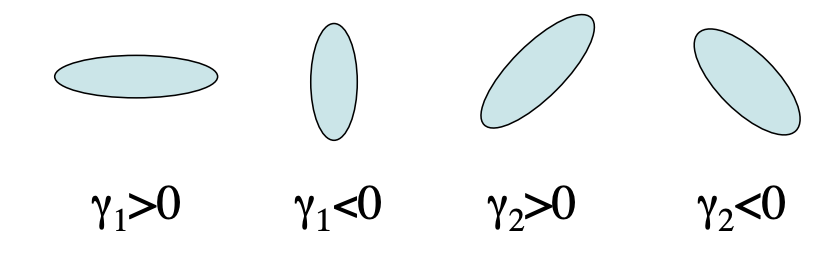
Figure taken from [these slides](http://mwhite.berkeley.edu/Lensing/SantaFe04.pdf)

**g1**

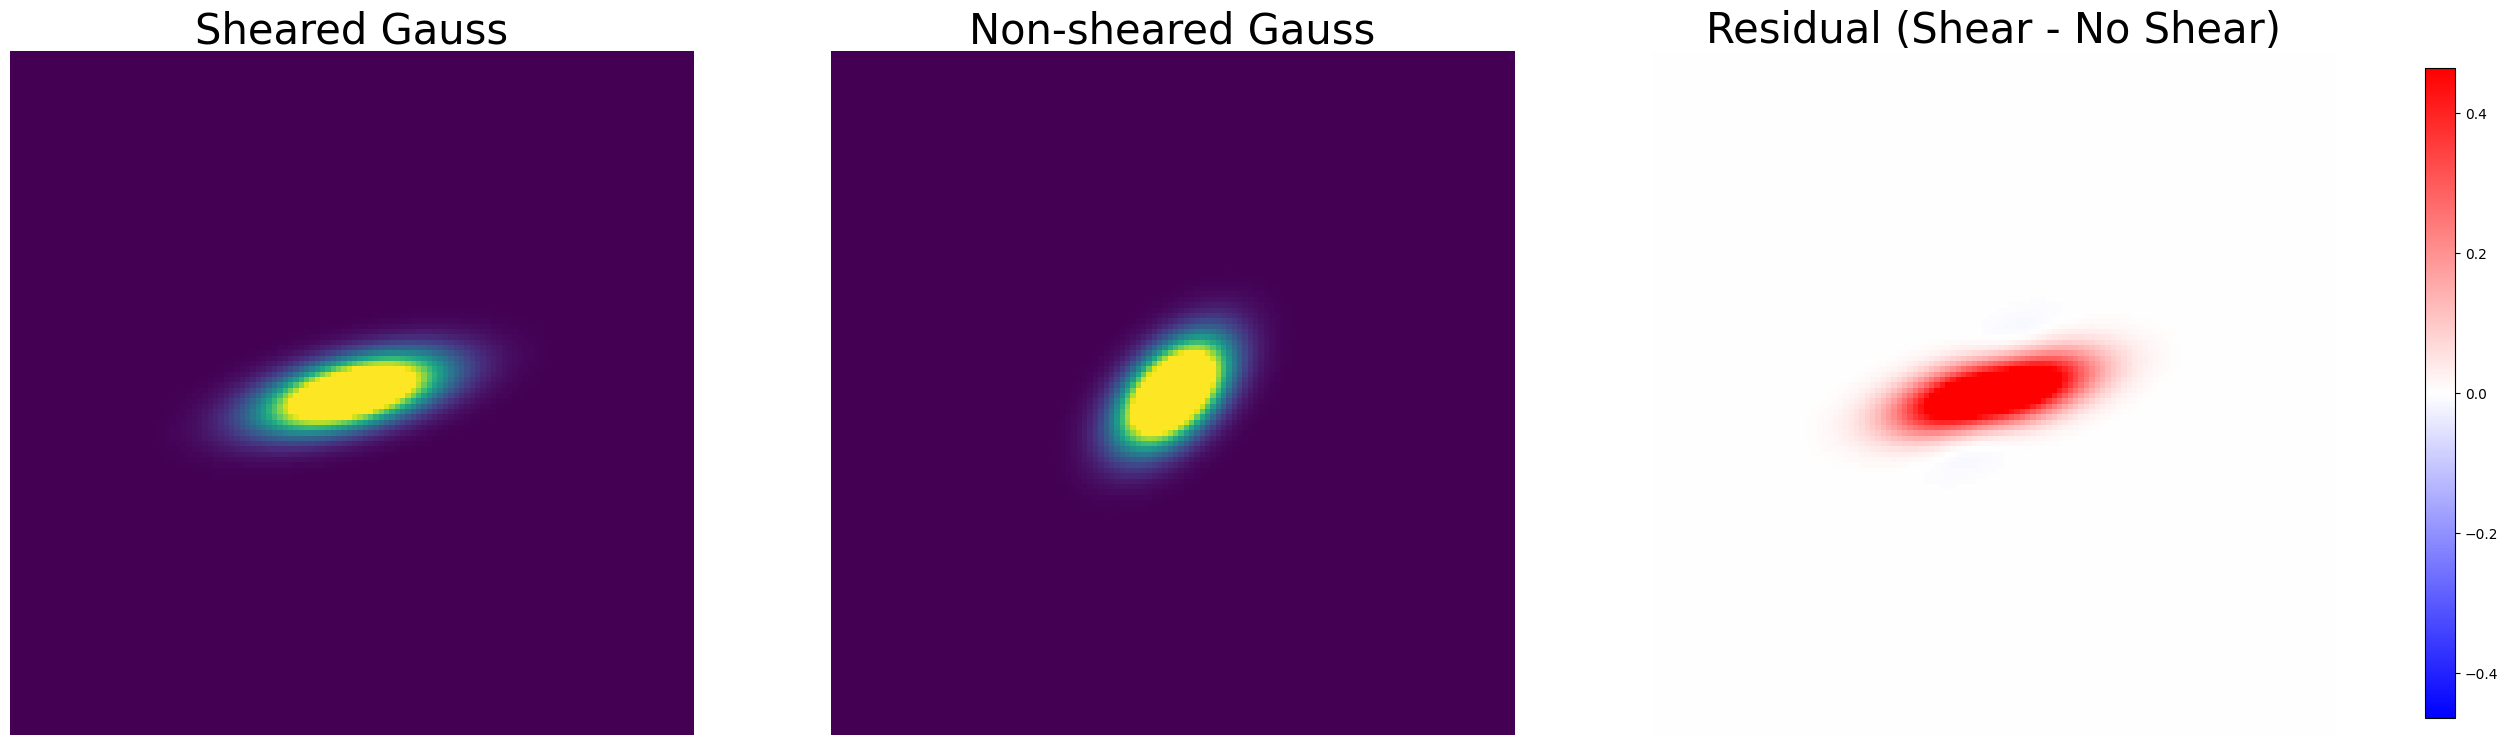

In [7]:
visualize_shear(sigma_x=1.0,
                sigma_y=1.0,
                rho=0.5,
                g1=0.4, 
                g2=0.0, 
                kappa=0.0)

**g2**

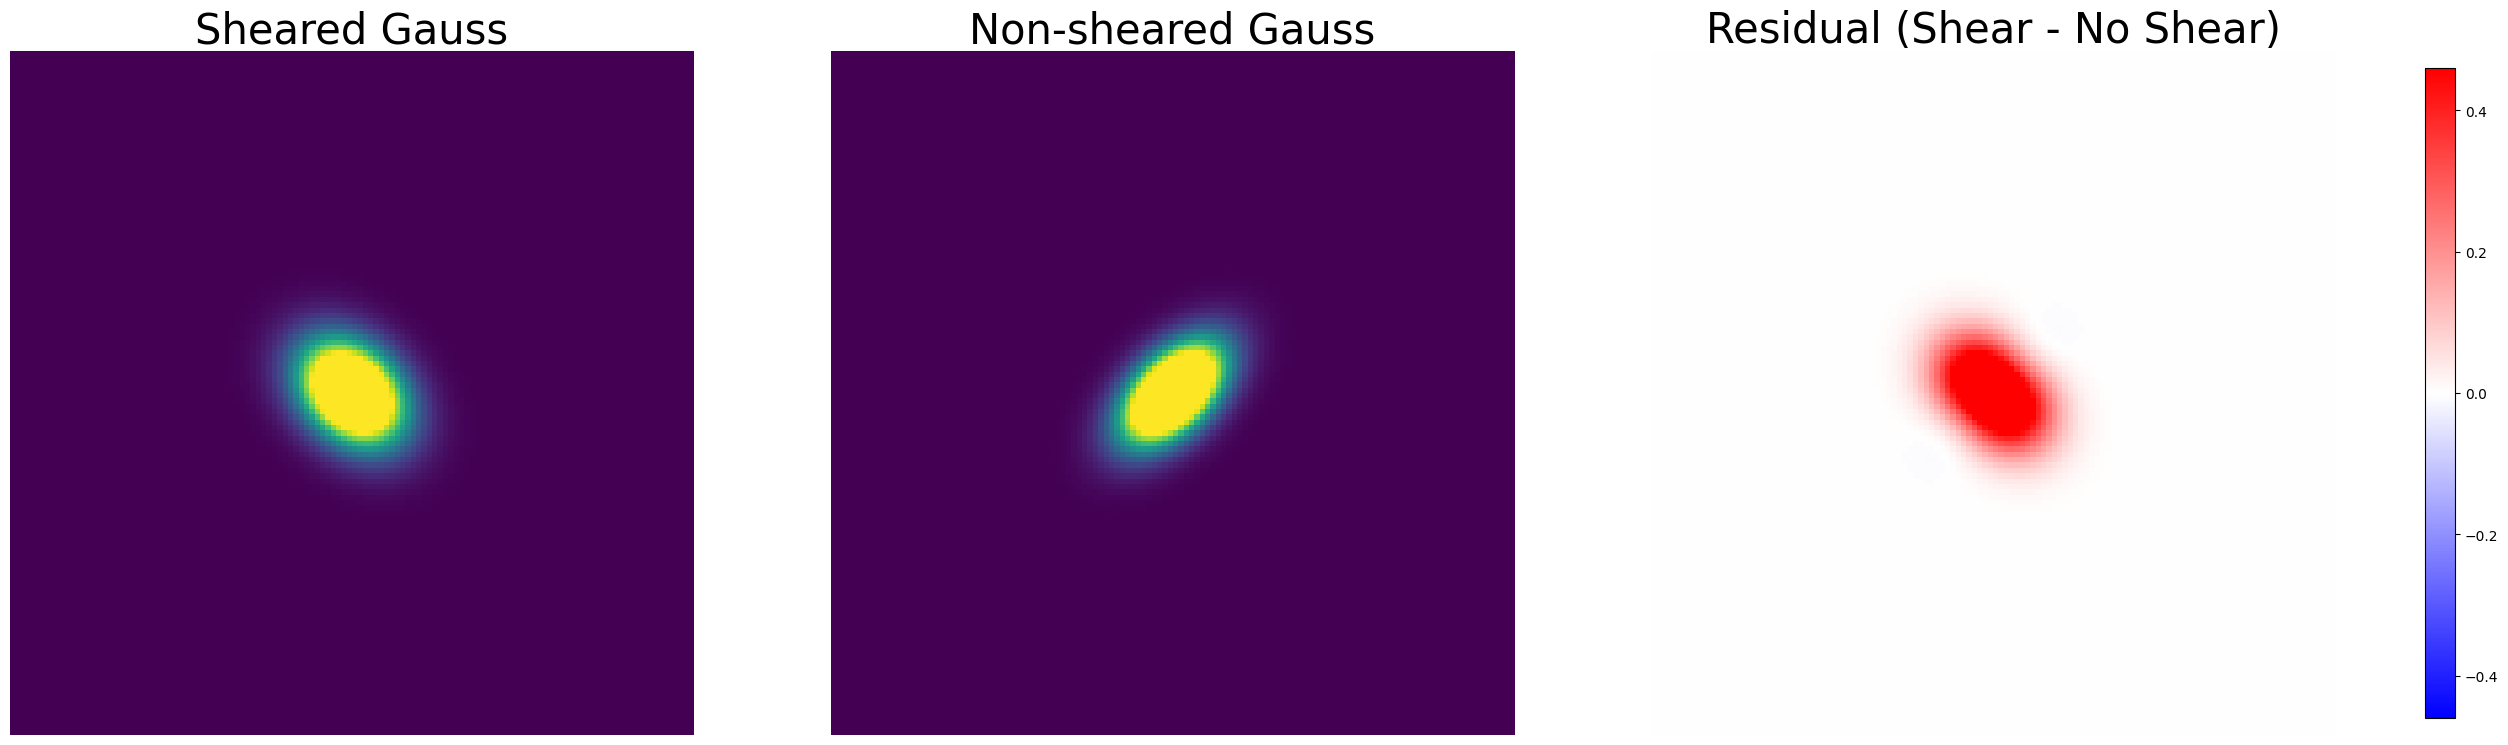

In [8]:
visualize_shear(sigma_x=1.0,
                sigma_y=1.0,
                rho=0.5,
                g1=0.0, 
                g2=-0.4, 
                kappa=0.0)

**g1+g2**

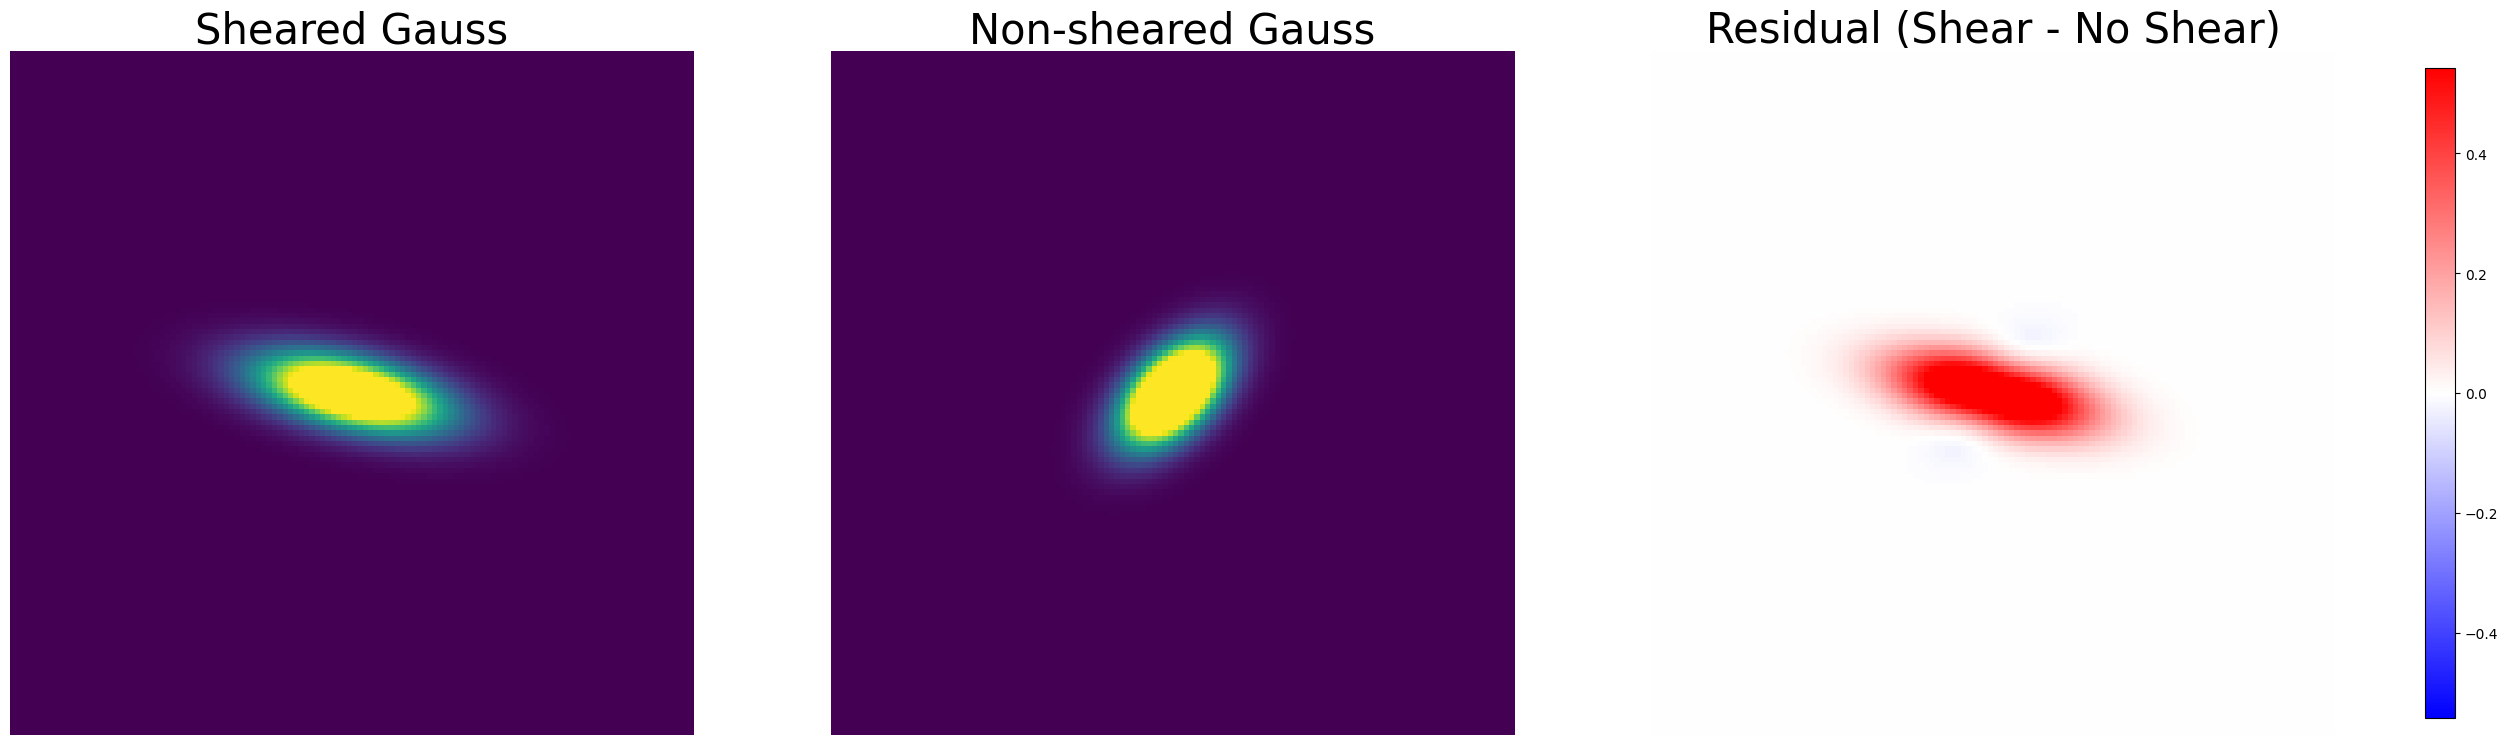

In [9]:
visualize_shear(sigma_x=1.0,
                sigma_y=1.0,
                rho=0.5,
                g1=0.4, 
                g2=-0.4, 
                kappa=0.0)

**kappa**

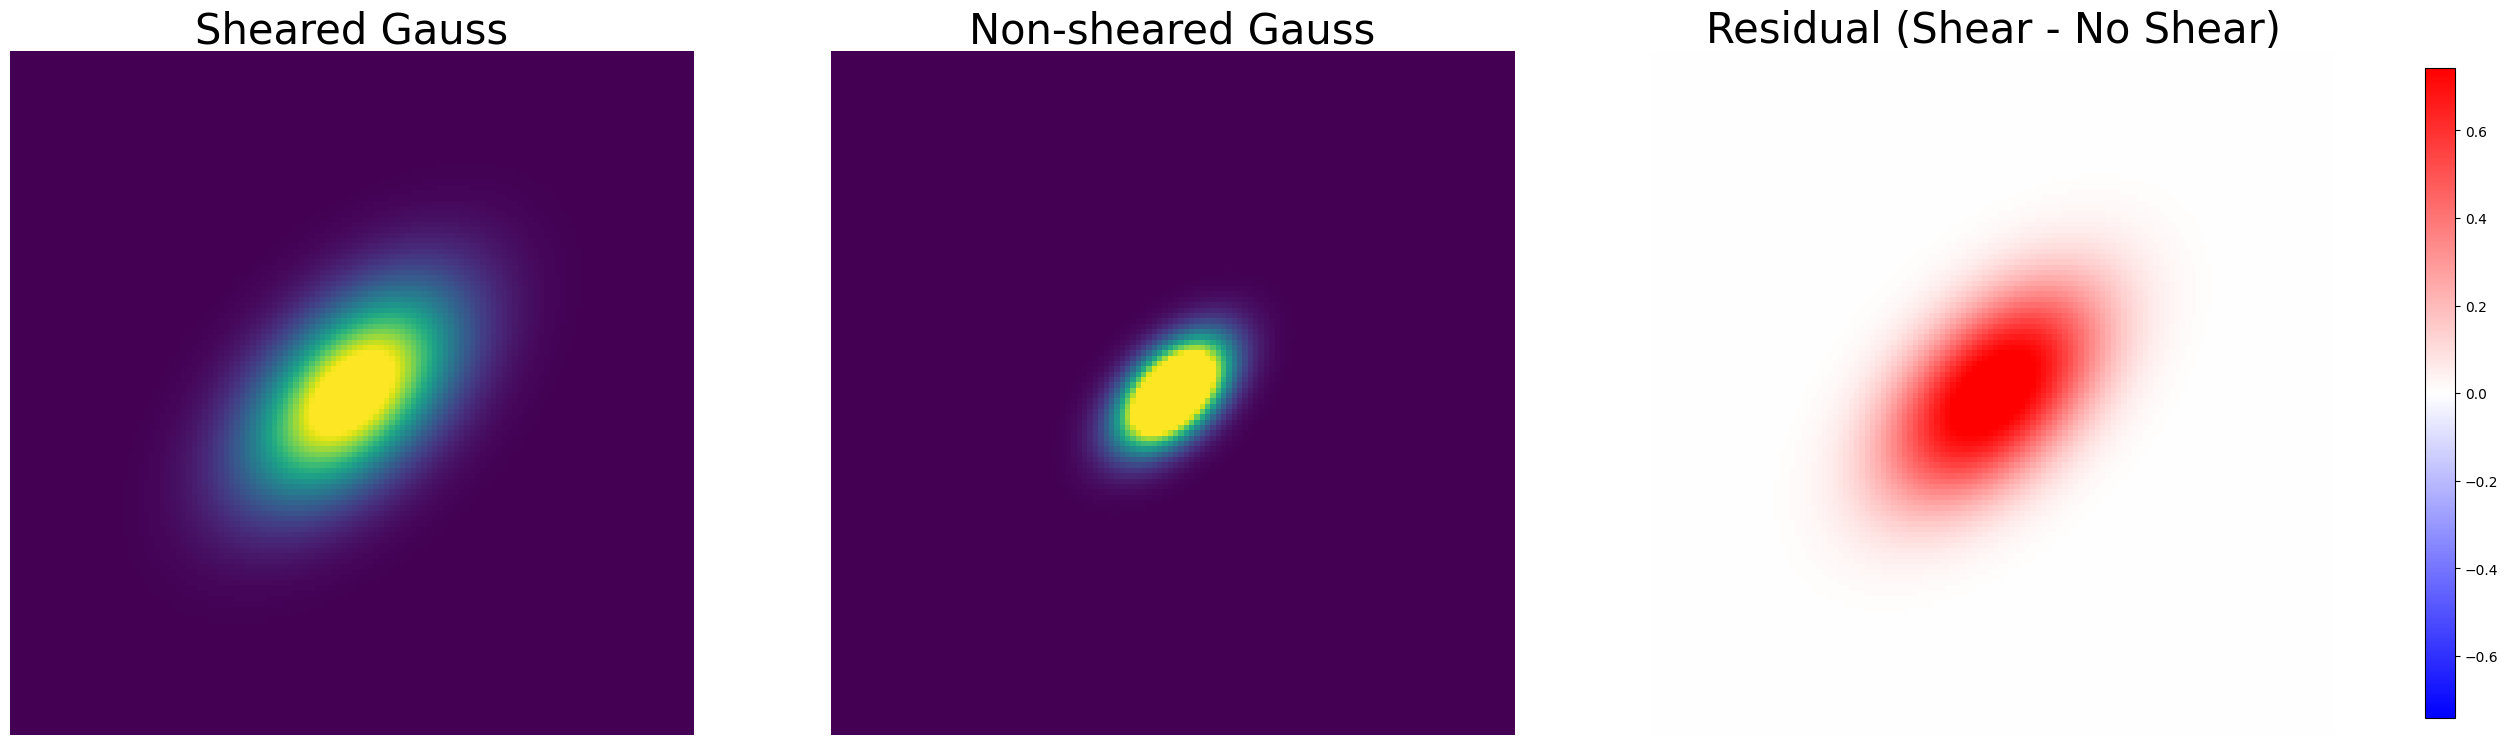

In [10]:
visualize_shear(sigma_x=1.0,
                sigma_y=1.0,
                rho=0.5,
                g1=0.0, 
                g2=0.0, 
                kappa=0.5)

**kappa+g1+g2**

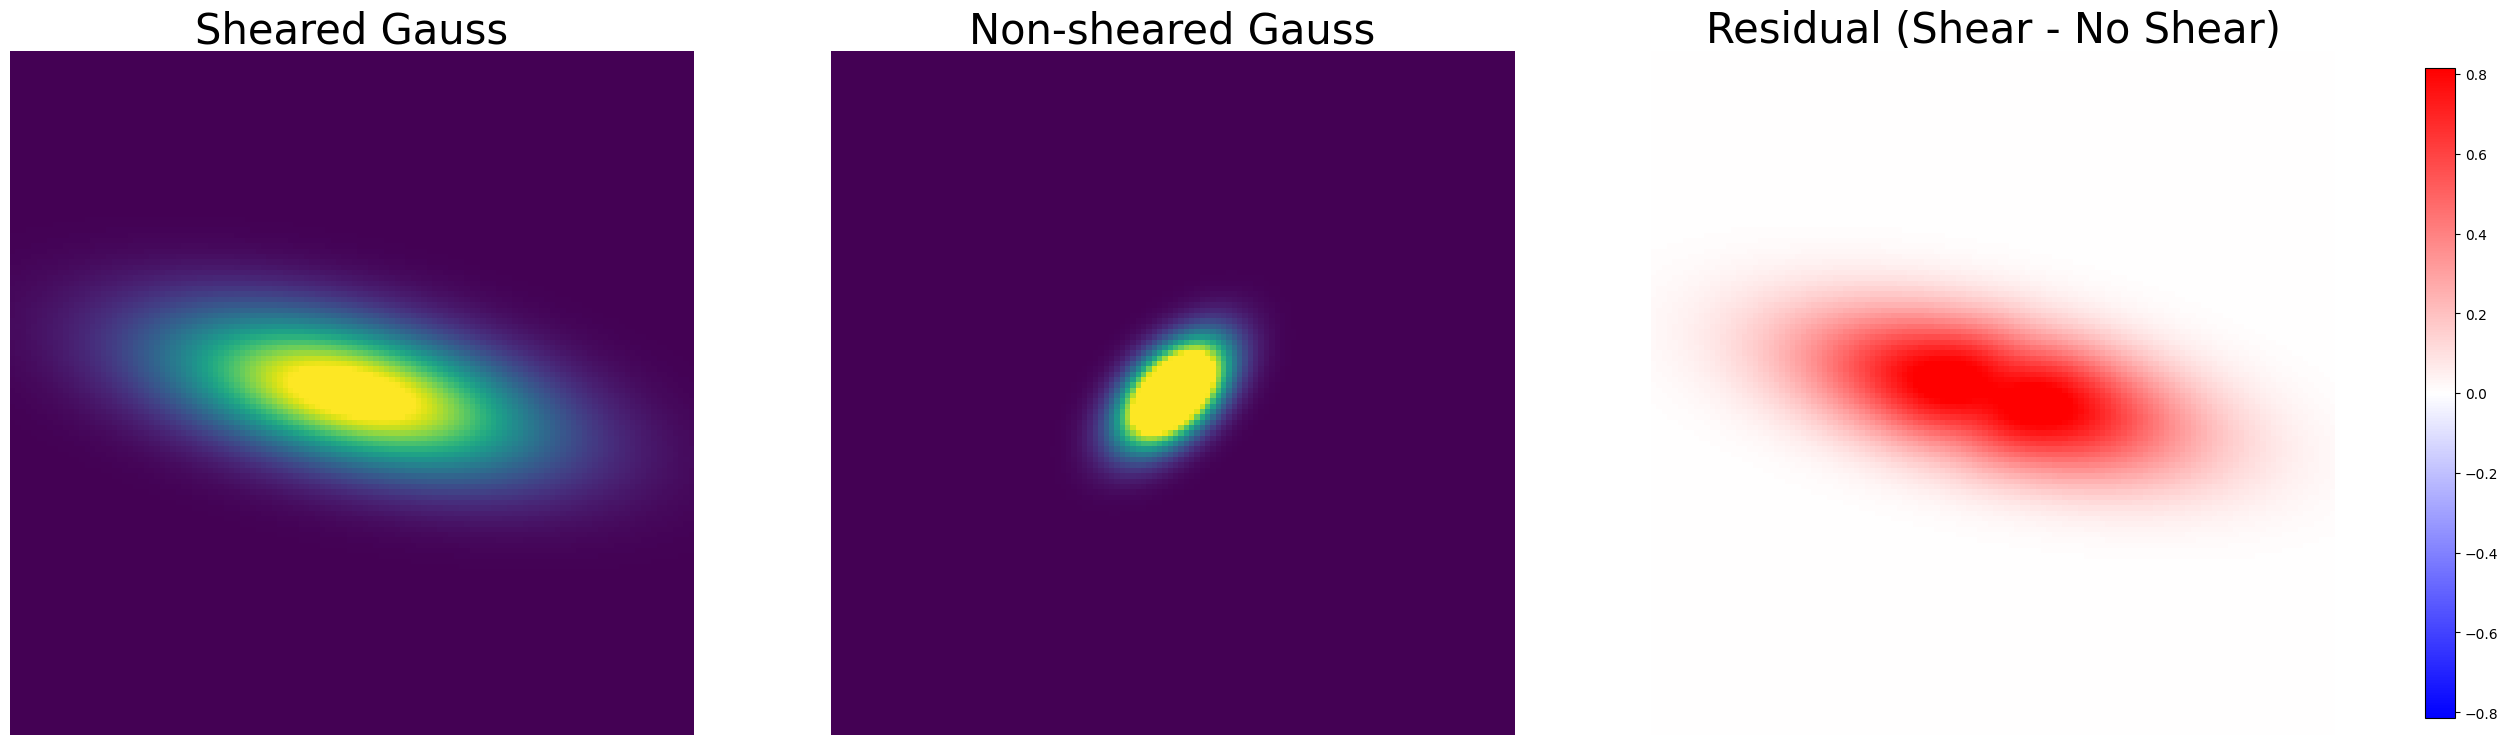

In [11]:
visualize_shear(sigma_x=1.0,
                sigma_y=1.0,
                rho=0.5,
                g1=0.4, 
                g2=-0.4, 
                kappa=0.5)

# 2. Shearing using `GalSim`:  [demo2](https://github.com/GalSim-developers/GalSim/blob/releases/2.4/examples/demo2.py) is a good beginner guide

Using [galsim](http://galsim-developers.github.io/GalSim/_build/html/tutorials.html#demo-1) for creating the 2 2D gaussian galaxies. Check out the [galsim github](https://github.com/GalSim-developers/GalSim/tree/releases/2.4/examples) for demos of `galsim`.

In [12]:
def create_gauss_gal(gal_flux=1.e5, 
                     gal_sigma=2.0,
                     psf_sigma=1.0, 
                     pixel_scale=0.2,
                     shear_on=False,
                     g1=0.1,
                     g2=0.2,
                     noise_on=False,
                     noise=30.):
    """
    Function that creates a 2D gaussian galaxy using Galsim.
    
    Args:
    -----
        gal_flux: float
            Total counts on the image
            Defaults to 1.e5
        gal_sigma: float
            The value of sigma of the profile. Typically given in arcsec.
            Defaults to 2.0
        psf_sigma: float
            The value of sigma of the PSF profile. Typically given in arcsec.
            Defaults to 1.0
        pixel_scale: float
            The value of how many arcsec/pixel there are. 
            Defaults to 0.2
        noise: float
            Standard deviation of the counts in each pixel.
            Defaults to 30.
        noise_on: Boolean
            Toggles between having a noisy gaussian image or noise-free.
            Defaults to False.
        shear_on: Boolean
            Toggles between shearing the galaxy or not. A shear is an operation
            that transforms a circle into anellipsde with minor-to-major axis
            ratio b/a, with position angle beta, while conserving the area. There
            are multiple ways to define shear, but the version we used is called
            the reduced shear ie:
            
                g1 = |g| cos(2*beta)
                g2 = |g| sin(2*beta)
               |g| = (a-b)/(a+b)
                 g = |g| exp(2i*beta)
            
            Taken as imaginary and real parts, the real part (g1) of the complex
            ellipticity describes the elongation along the coordiante axes, while
            the imaginary part (g2) describes the elongation at 45° from the axes.
        g1: float
            The first reduced shear component that describes the elongation along 
            the coordinate axes. 
            Defaults to 0.1.
        g2: float
            The second reduced shear component that describes the elongation at 45°
            from the coordinate axes.
            Defaults to 0.2
            
    Returns:
        gal: np.ndarray
            The constructed gaussian galaxy image.
            
    """
    # Define the galaxy profile
    gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma)
    # Shear the galaxy by some value.
    # There are quite a few ways you can use to specify a shape.
    # q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
    # e, beta      Ellipticity and position angle: |e| = (1-q^2)/(1+q^2)
    # g, beta      ("Reduced") Shear and position angle: |g| = (1-q)/(1+q)
    # eta, beta    Conformal shear and position angle: eta = ln(1/q)
    # e1,e2        Ellipticity components: e1 = e cos(2 beta), e2 = e sin(2 beta)
    # g1,g2        ("Reduced") shear components: g1 = |g| cos(2 beta), g2 = |g| sin(2 beta)
    # eta1,eta2    Conformal shear components: eta1 = eta cos(2 beta), eta2 = eta sin(2 beta)
    if shear_on == True:  
        gal = gal.shear(g1=g1, g2=g2)
    else:
        pass

    # Define the PSF profile
    psf = galsim.Gaussian(flux=1., sigma=psf_sigma) # PSF flux should always = 1

    # Final profile is the convolution of these
    # Can include any number of things in the list, all of which are convolved
    # together to make the final flux profile.
    final = galsim.Convolve([gal, psf])

    # Draw the image with a particular pixel scale, given in arcsec/pixel.
    # The returned image has a member, added_flux, which is gives the total flux actually added to
    # the image.  One could use this value to check if the image is large enough for some desired
    # accuracy level.  Here, we just ignore it.
    image = final.drawImage(scale=pixel_scale, nx=128, ny=128)

    # Add Gaussian noise to the image with specified sigma
    if noise_on == True:
        image.addNoise(galsim.GaussianNoise(sigma=noise))
        return image.array
    else:
        return image.array
    
def visualize_FT(img):
    
    f, fshift, mag = FFT_IFFT_calc(img=img, FFT=True)
    ifft = FFT_IFFT_calc(img=fshift, FFT=False)
    fig, axes = plt.subplots(1, 3, figsize=(30,26))
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('Input', fontsize=30)
    axes[1].imshow(mag)
    axes[1].axis('off')
    axes[1].set_title('FFT', fontsize=30)
    axes[2].imshow(ifft.real)
    axes[2].axis('off')
    axes[2].set_title('IFFT(FFT(Input))', fontsize=30)
   

    plt.tight_layout()
    plt.show()

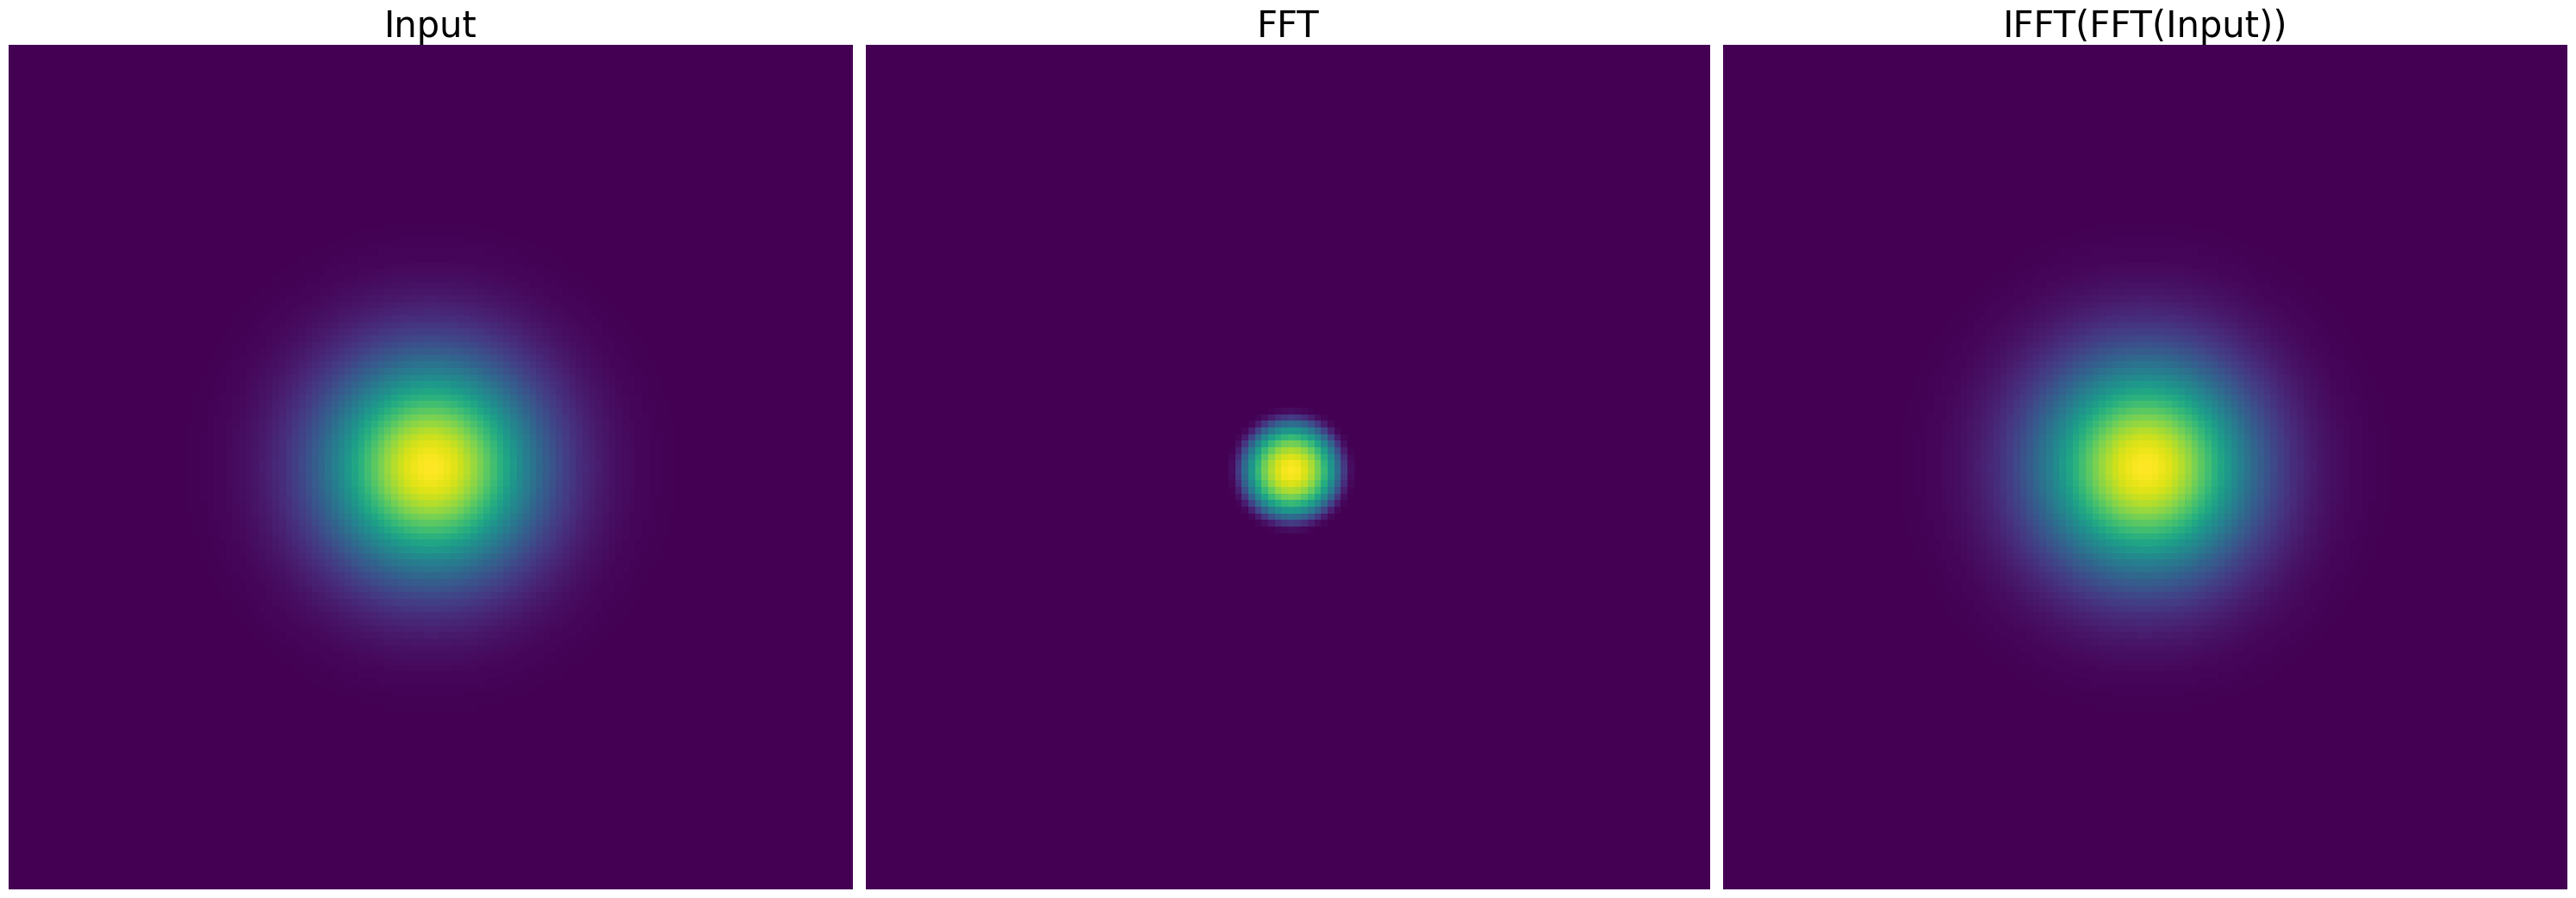

In [13]:
# Acts as the pre-sheared galaxy
round_gauss = create_gauss_gal(gal_flux=1.e5, 
                                   gal_sigma=2.0,
                                   psf_sigma=1.0, 
                                   pixel_scale=0.2)
visualize_FT(round_gauss)

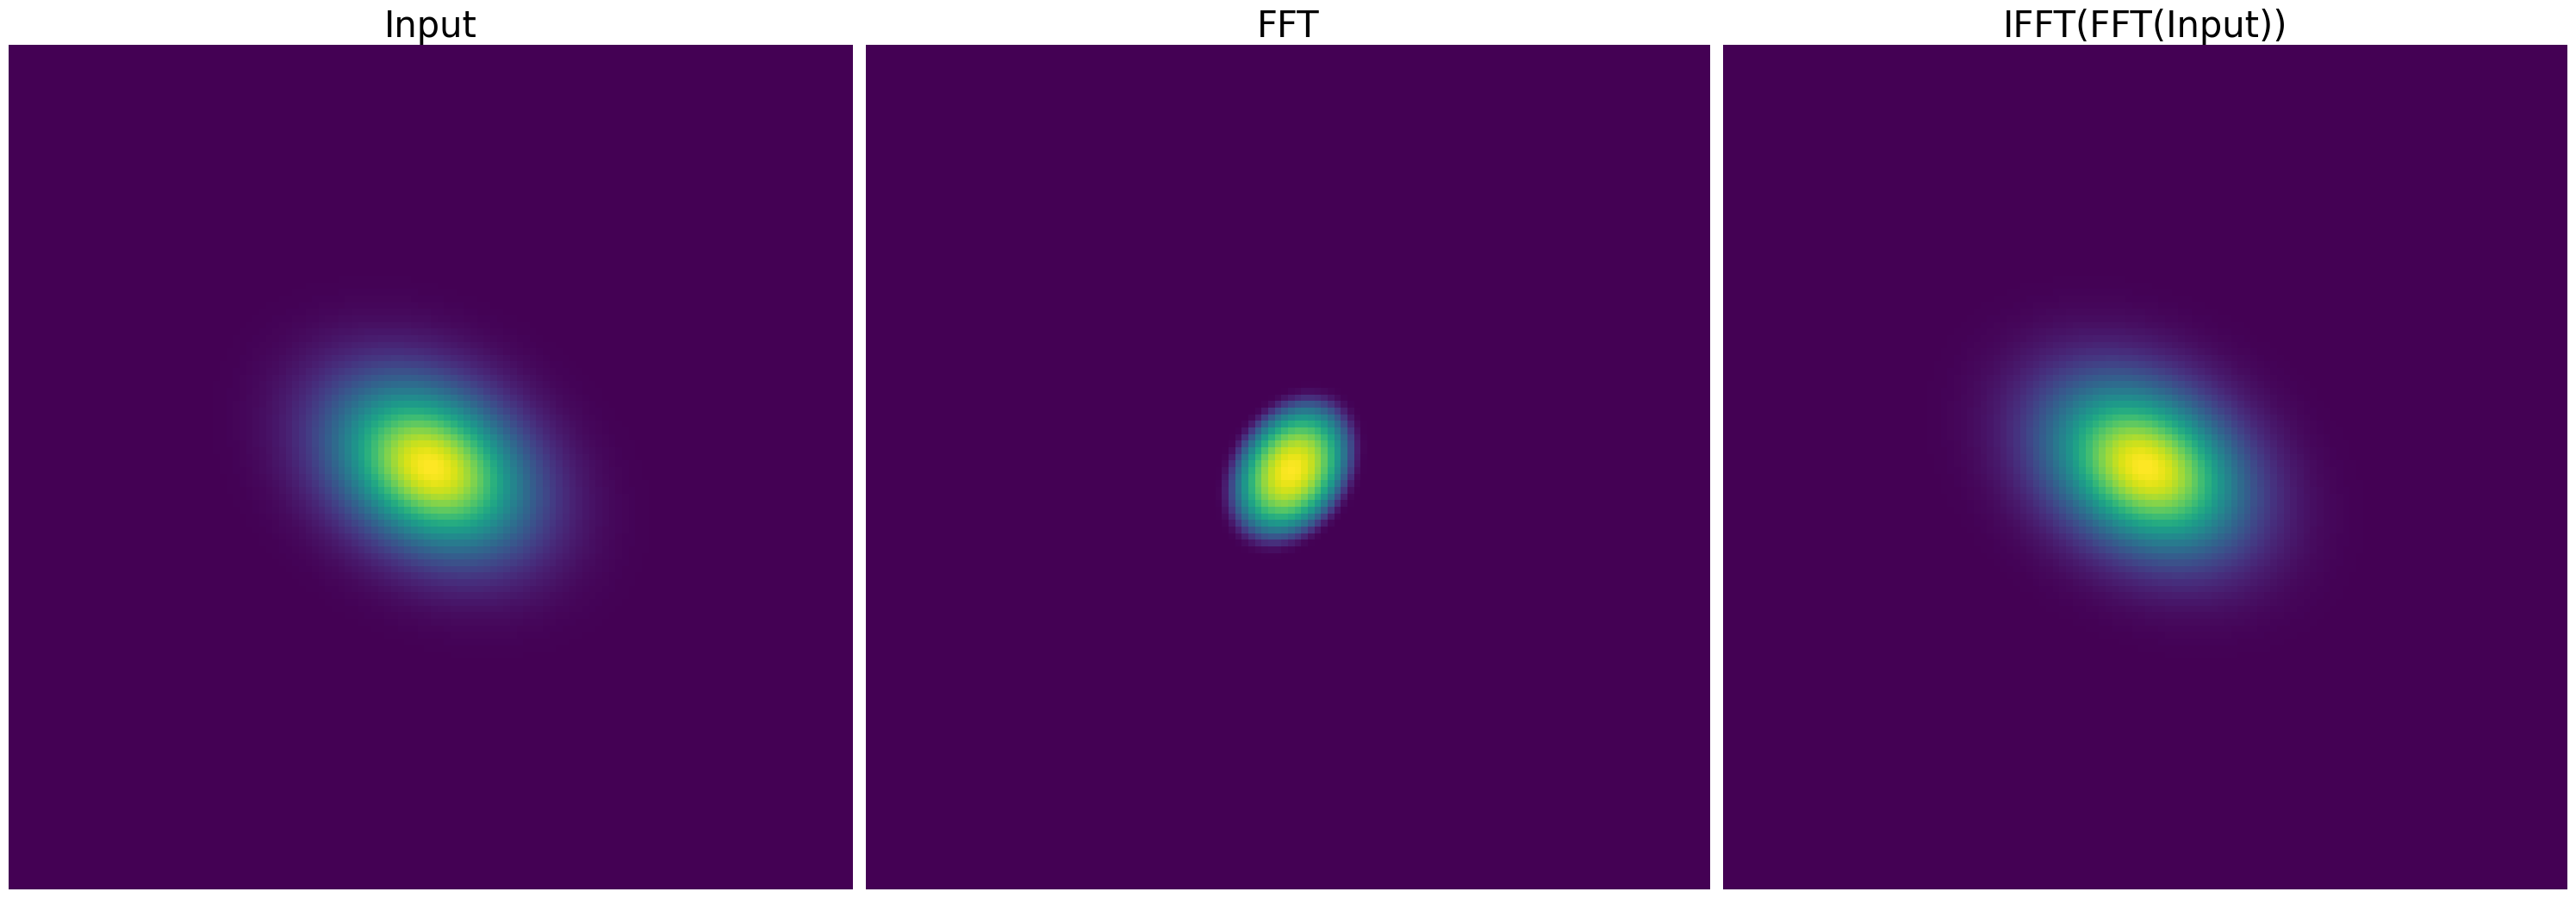

In [14]:
post_shear = create_gauss_gal(gal_flux=1.e5, 
                               gal_sigma=1.5,
                               psf_sigma=1.0, 
                               pixel_scale=0.2,
                               shear_on=True,
                               g1=0.1,
                               g2=0.2)
visualize_FT(post_shear)

So from doing the 2D FT Transform by hand we see the main points ie.:
1. The FT of a Gaussian is a Gaussian of reciprocal width. Meaning that if the input Gaussian is really spread out the FFT Gaussian will be really narrow and vice versa.
2. The flipping of the data in FT.

# 3. Noise effects of on Gaussians (Uses `GalSim`)

In [15]:
# Acts as the pre-sheared galaxy
low_noise = create_gauss_gal(gal_flux=1.e5, 
                                   gal_sigma=2.0,
                                   psf_sigma=1.0, 
                                   pixel_scale=0.2,
                                   noise=1.,
                                   noise_on=True)

f_low, fshift_low, mag_low = FFT_IFFT_calc(img=low_noise, FFT=True)
ifft_low = FFT_IFFT_calc(img=fshift_low, FFT=False)


# Acts as the pre-sheared galaxy
high_noise = create_gauss_gal(gal_flux=1.e5, 
                                   gal_sigma=2.0,
                                   psf_sigma=1.0, 
                                   pixel_scale=0.2,
                                   noise=30.,
                                   noise_on=True)
f_high, fshift_high, mag_high = FFT_IFFT_calc(img=high_noise, FFT=True)
ifft_high = FFT_IFFT_calc(img=fshift_high, FFT=False)

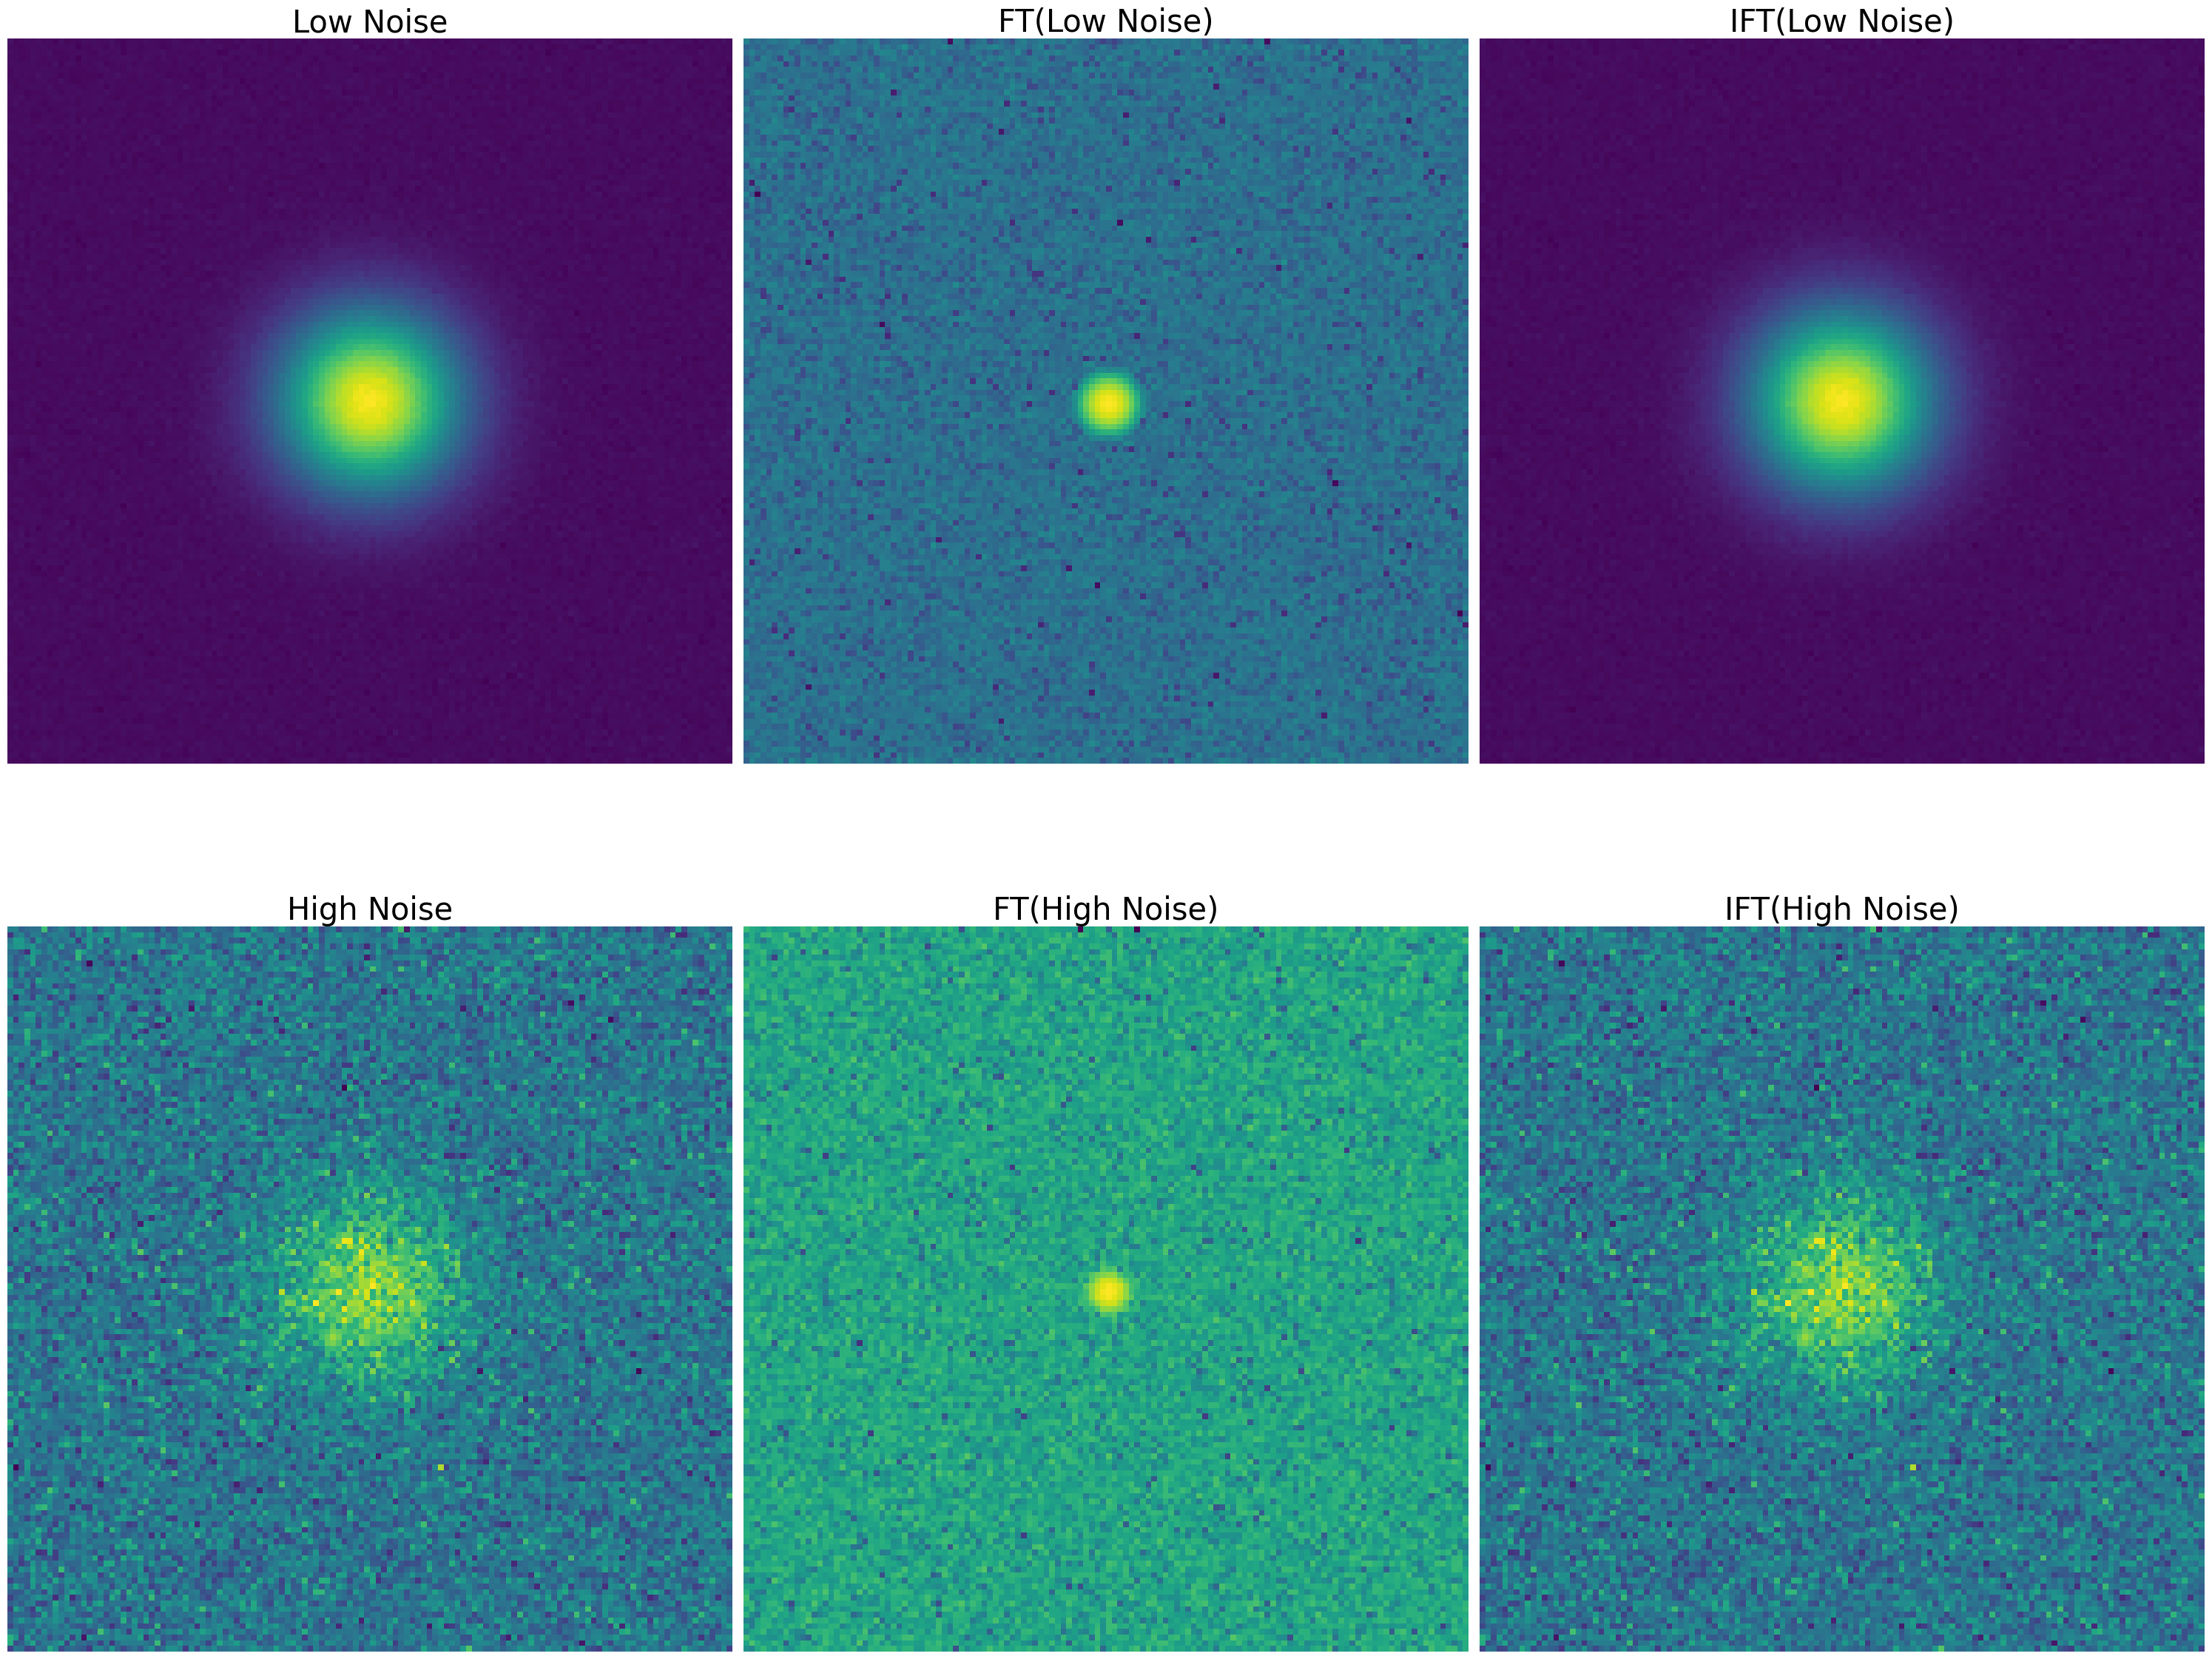

In [16]:
vmax_low = np.percentile(mag_low.real, (99))
vmin_low = -vmax_low

vmax_high = np.percentile(mag_high.real, (99))
vmin_high = -vmax_high


fig, axes = plt.subplots(2, 3, figsize=(30,26))
axes[0,0].imshow(low_noise)
axes[0,0].axis('off')
axes[0,0].set_title('Low Noise', fontsize=30)
axes[0,1].imshow(mag_low)
axes[0,1].axis('off')
axes[0,1].set_title('FT(Low Noise)', fontsize=30)
# axes[0,2].imshow(ifft_low.real, vmax=vmax_low, vmin=vmin_low)
axes[0,2].imshow(ifft_low.real)
axes[0,2].axis('off')
axes[0,2].set_title('IFT(Low Noise)', fontsize=30)
axes[1,0].imshow(high_noise)
axes[1,0].axis('off')
axes[1,0].set_title('High Noise', fontsize=30)
# axes[1,1].imshow(mag_high, vmax=vmax_high, vmin=vmin_high)
axes[1,1].imshow(mag_high)
axes[1,1].axis('off')
axes[1,1].set_title('FT(High Noise)', fontsize=30)
axes[1,2].imshow(ifft_high.real)
axes[1,2].axis('off')
axes[1,2].set_title('IFT(High Noise)', fontsize=30)


plt.tight_layout()
plt.show()

NameError: name 'vmin' is not defined

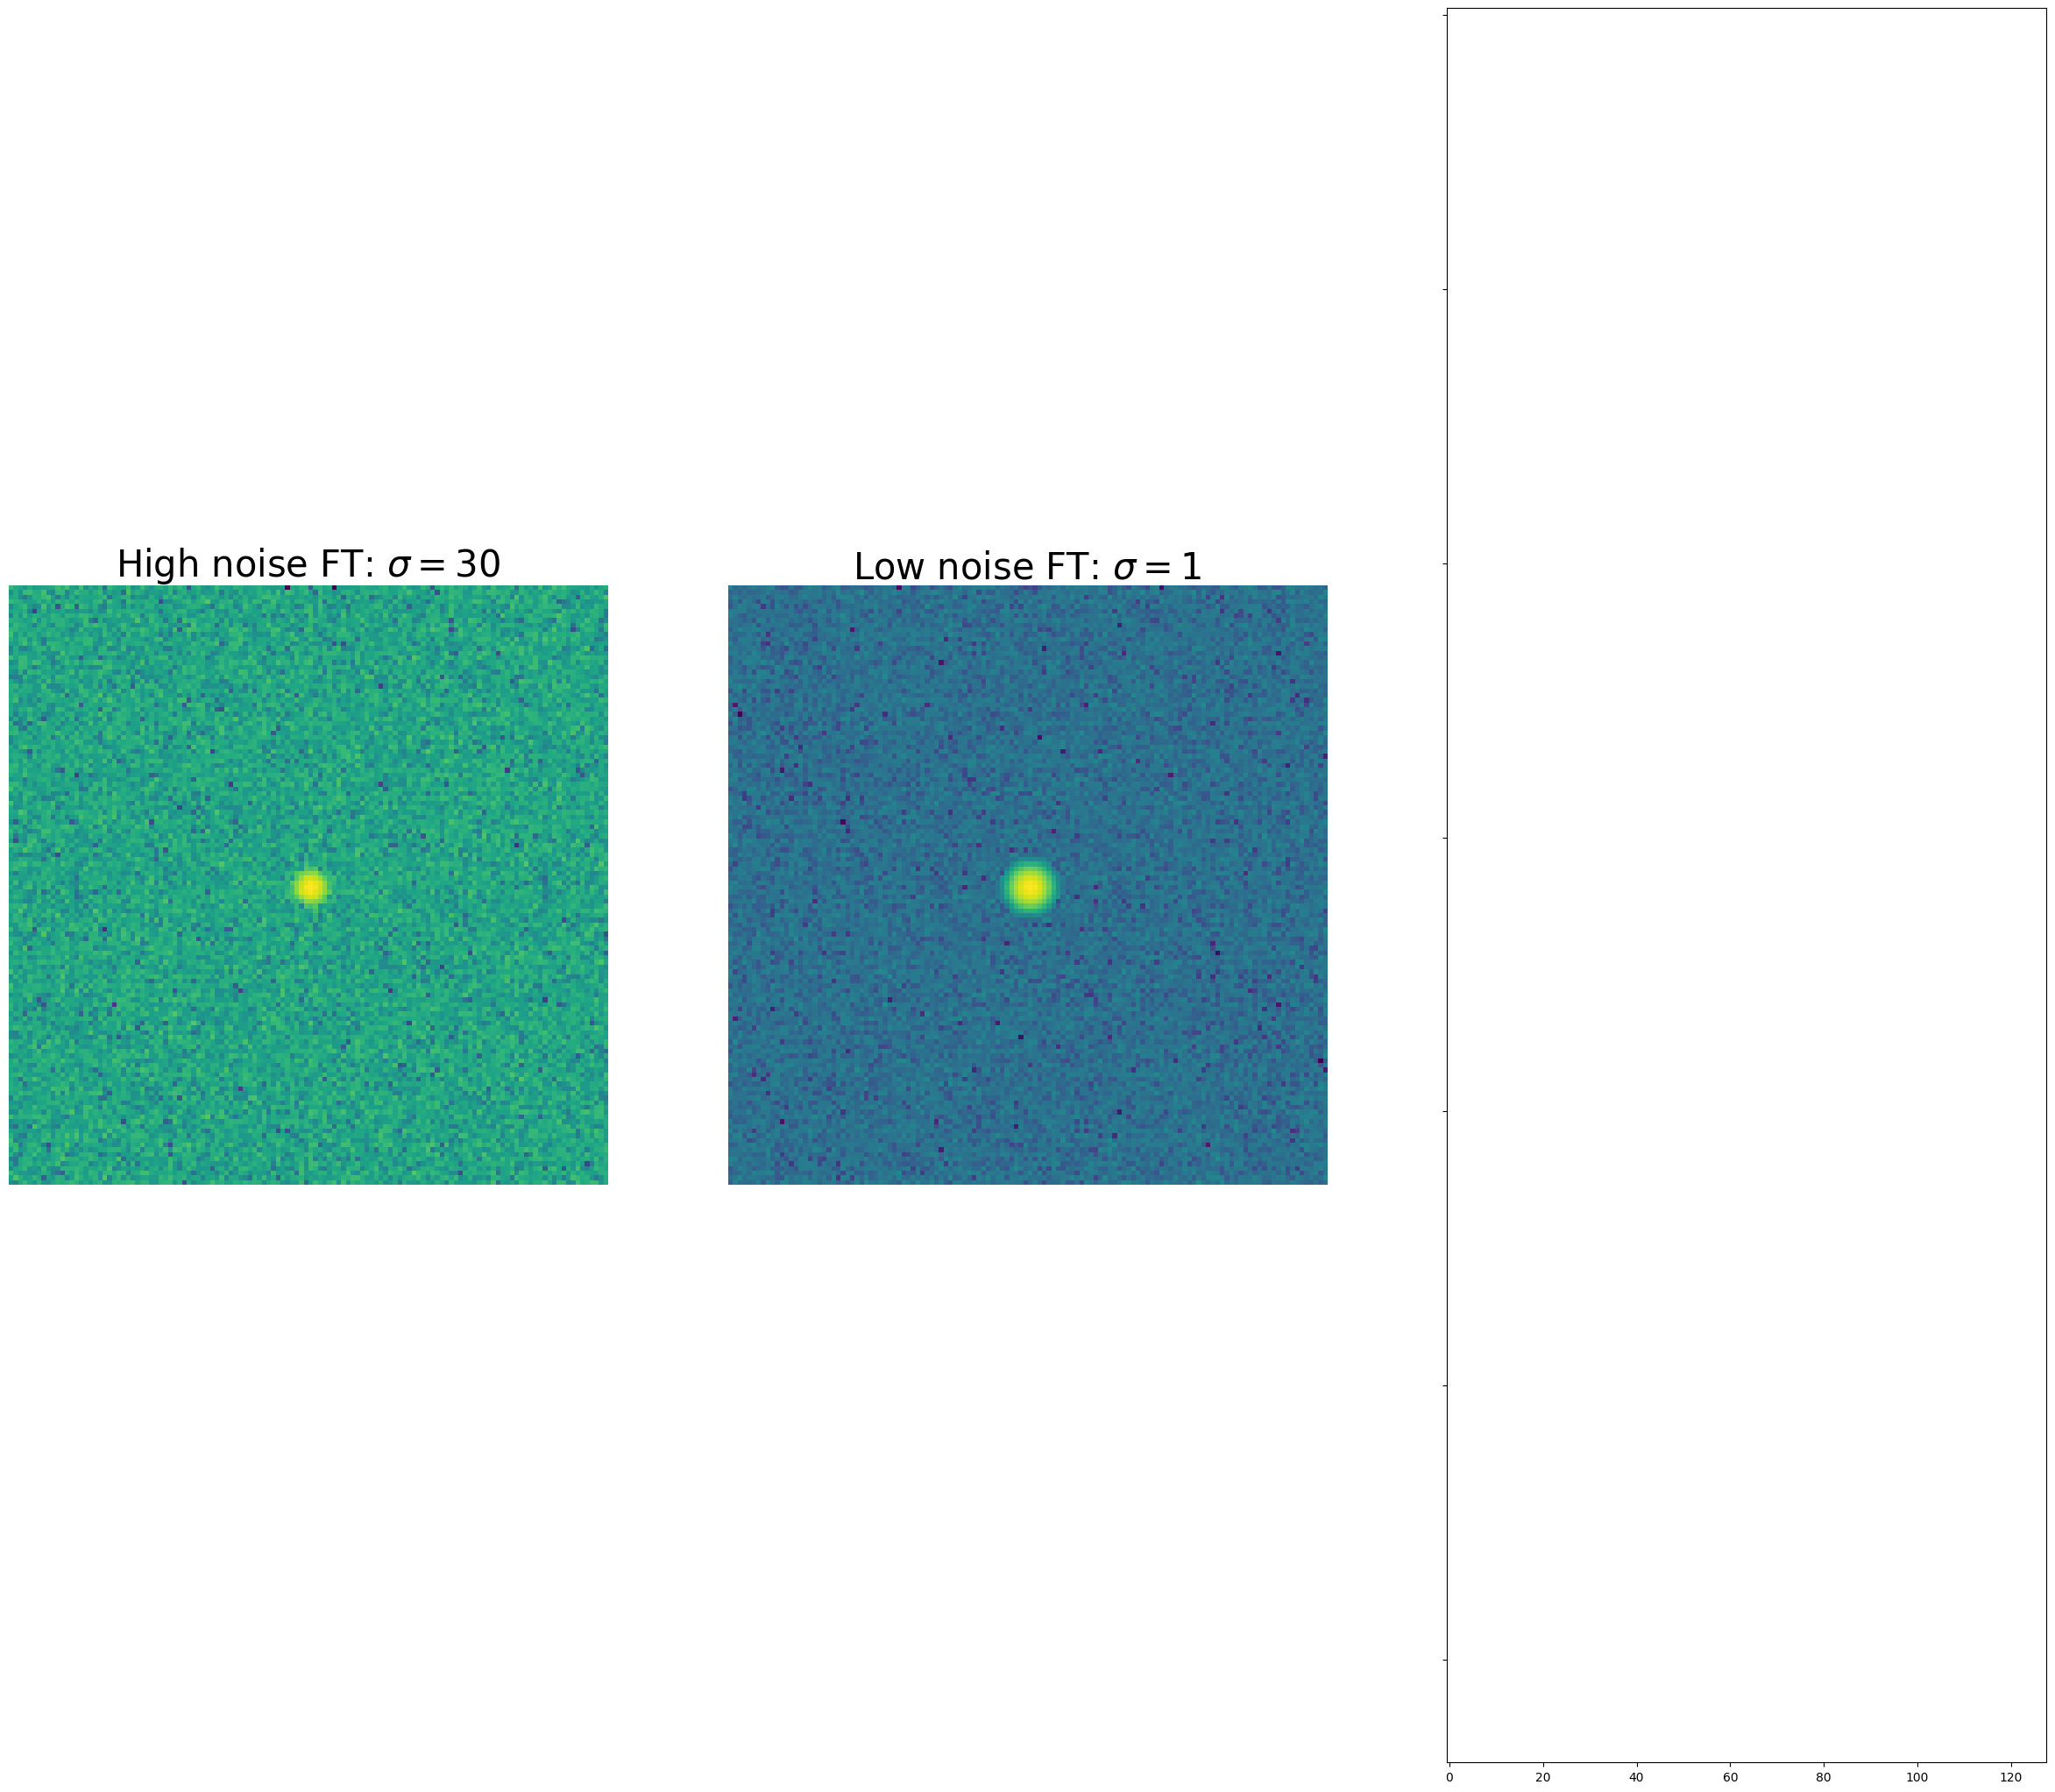

In [17]:
residual = mag_high - mag_low

fig, axes = plt.subplots(1, 3, figsize=(30,26), sharex=True, sharey=True)
axes[0].imshow(mag_high.real)
axes[0].axis('off')
axes[0].set_title('High noise FT: $\sigma = 30$', fontsize=30)
axes[1].imshow(mag_low.real)
axes[1].axis('off')
axes[1].set_title('Low noise FT: $\sigma = 1$', fontsize=30)
im = axes[2].imshow(residual.real,vmin=vmin, vmax=vmax, cmap='bwr')
axes[2].axis('off')
axes[2].set_title('Residual (High-Low)', fontsize=30)

cax = plt.axes([0.93, 0.37, 0.01, 0.25])
fig.colorbar(im, cax=cax, ax=axes[2])
print("Sum of high noise image =", np.sum(mag_high.real))
print("Sum of low noise image =", np.sum(mag_low.real))


# fig.tight_layout()
plt.show()